In [56]:
import numpy as np
import netCDF4 as nc
import f90nml
import os
import matplotlib.pyplot as plt
from salishsea_tools import bio_tools as bio
from salishsea_tools import visualisations
from matplotlib.colors import LinearSegmentedColormap
import cmocean
%matplotlib inline

In [40]:
bathy = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

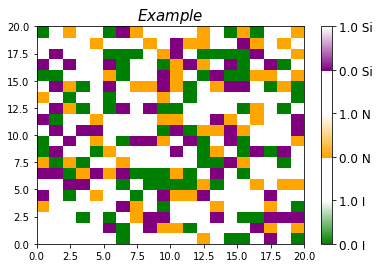

In [41]:
vmax = 5.0
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'green'),
                                                    (1 / vmax, 'white'),
                                                    (1.99 / vmax, 'white'),
                                                    (2 / vmax, 'orange'),
                                                    (3 / vmax, 'white'),
                                                    (3.99 / vmax, 'white'),
                                                    (4 / vmax, 'purple'),
                                                    (5 / vmax, 'white')]
                                        )
fig, ax = plt.subplots()
mesh1 = ax.pcolormesh(np.random.randint(0,6, size=(20,20)), cmap = cmap)
ticks = [0,1,2,3,4,5]
cbar1 = fig.colorbar(mesh1, ax=ax)
cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels(['0.0 I', '1.0 I', '0.0 N', '1.0 N', '0.0 Si', '1.0 Si'])
ax.set_title('$Example$', fontsize =15)
cbar1.ax.tick_params(labelsize = 12)

In [94]:
def plot_excess_silicate(ptrc):
    with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as m:
        tmask=m.variables['tmask'][:,:,:,:]
    NO= (ptrc.variables['nitrate'][19,:,:,:] + ptrc.variables['nitrate'][18,:,:,:]) * 0.5
    NH= (ptrc.variables['ammonium'][19,:,:,:] + ptrc.variables['ammonium'][18,:,:,:]) * 0.5
    Si= (ptrc.variables['silicon'][19,:,:,:] + ptrc.variables['silicon'][18,:,:,:]) * 0.5
    
    fig, ax = plt.subplots(figsize = (15,3))
    cbar1 = visualisations.contour_thalweg(ax, Si - 2 * (NO + NH), bathy, mesh,
                                           cmap = 'bwr', 
                                           method='pcolormesh',land_colour='gray',
                                           mesh_args={'vmin':-30, 'vmax':30})
    ax.set_title('Si*', fontsize = 15)
    
    ax.set_ylim(35,0)
    plt.tight_layout()

In [95]:
def limit_along_thalweg(path, diafile, ptrcfile, phytoplankton):
    resDir=path
    nampisprod=bio.load_nml_bio(resDir,'nampisprod',
                            namRefDir='/data/vdo/MEOPAR/NEMO-3.6-code/NEMOGCM/CONFIG/SMELT/EXP00/')
    fdia=nc.Dataset(os.path.join(resDir,diafile))
    fptc=nc.Dataset(os.path.join(resDir,ptrcfile))
    with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as m:
        tmask=m.variables['tmask'][:,:,:,:]
    I=fdia.variables['PAR'][9,:,:,:]
    NO= (fptc.variables['nitrate'][19,:,:,:] + fptc.variables['nitrate'][18,:,:,:]) * 0.5
    NH= (fptc.variables['ammonium'][19,:,:,:] + fptc.variables['ammonium'][18,:,:,:]) * 0.5
    Si= (fptc.variables['silicon'][19,:,:,:] + fptc.variables['silicon'][18,:,:,:]) * 0.5
    if phytoplankton == 'N':
        fig, ax = plt.subplots(2,1,figsize = (14,6))
        cbar1 = visualisations.contour_thalweg(ax[0], NO, bathy, mesh, 
                                               cmap = 'Greens', method='pcolormesh',
                                              mesh_args={'vmin':0,'vmax':40})
        cbar2 = visualisations.contour_thalweg(ax[1], NH, bathy, mesh,
                                               cmap = 'Purples', method='pcolormesh',
                                              mesh_args={'vmin':0,'vmax':7})
        ax[0].set_title('Nitrate', fontsize = 15)
        ax[1].set_title('Ammonium', fontsize = 15)
    else:
        D,M,N = bio.calc_p_limiters(I,NO,NH,Si,tmask[0,:,:,:],nampisprod)
        if phytoplankton == 'dia':
            fig, ax = plt.subplots(3,1,figsize = (18,10))
            cbar1 = visualisations.contour_thalweg(ax[0], D['limiter'], bathy, mesh, 
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5})
            cbar2 = visualisations.contour_thalweg(ax[1], D['limval'], bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5})
            cbar3 = visualisations.contour_thalweg(ax[2], D['NLim']+2, bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5},
                                               cbar_args={'boundaries':np.linspace(2,3,20)})
            ax[0].set_title('Limiting Variable for Diatoms', fontsize = 15)
            ax[1].set_title('Rate Limitation Factor for Diatoms', fontsize = 15)
            ax[2].set_title('Nitrate Limitation Value for Diatoms', fontsize = 15)
        elif phytoplankton == 'meso':
            fig, ax = plt.subplots(3,1,figsize = (18,10))
            cbar1 = visualisations.contour_thalweg(ax[0], M['limiter'], bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5})
            cbar2 = visualisations.contour_thalweg(ax[1], M['limval'], bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5})
            cbar3 = visualisations.contour_thalweg(ax[2], M['NLim']+2, bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5},
                                               cbar_args={'boundaries':np.linspace(2,3,20)})
            ax[0].set_title('Limiting Variable for $Mesodinium$', fontsize = 15)
            ax[1].set_title('Rate Limitation Factor for $Mesodinium$', fontsize = 15)
            ax[2].set_title('Nitrate Limitation Value for $Mesodinium$', fontsize = 15)
        elif phytoplankton == 'flag':
            fig, ax = plt.subplots(3,1,figsize = (18,10))
            cbar1 = visualisations.contour_thalweg(ax[0], N['limiter'], bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5})
            cbar2 = visualisations.contour_thalweg(ax[1], N['limval'], bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5})
            cbar3 = visualisations.contour_thalweg(ax[2], N['NLim']+2, bathy, mesh,
                                               cmap = cmap, method='pcolormesh',land_colour='gray',
                                               mesh_args={'vmin':0, 'vmax':5},
                                               cbar_args={'boundaries':np.linspace(2,3,20)})
            ax[0].set_title('Limiting Variable for Flagellates', fontsize = 15)
            ax[1].set_title('Rate Limitation Factor for Flagellates', fontsize = 15)
            ax[2].set_title('Nitrate Limitation Value for Flagellates', fontsize = 15)
        cbar1.set_ticks([0.2,2.2,4.2])
        cbar1.set_ticklabels(['I', 'N', 'Si'])
        cbar1.ax.tick_params(labelsize=12)
        cbar2.set_ticks([0,1,2,3,4,5])
        cbar2.set_ticklabels(['0.0 I','1.0 I','0.0 N','1.0 N','0.0 Si','1.0 Si'])
        cbar2.ax.tick_params(labelsize=12)
        cbar3.set_ticks([2,2.5,3])
        cbar3.set_ticklabels(['0.0','0.5','1.0'])
        cbar3.ax.tick_params(labelsize=12)
    for ax in ax:
        ax.set_ylim(35,0)
    plt.tight_layout()

# January 2015

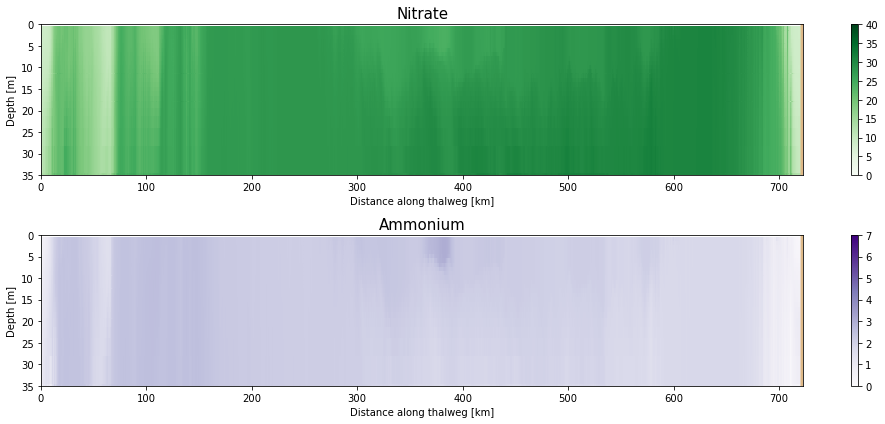

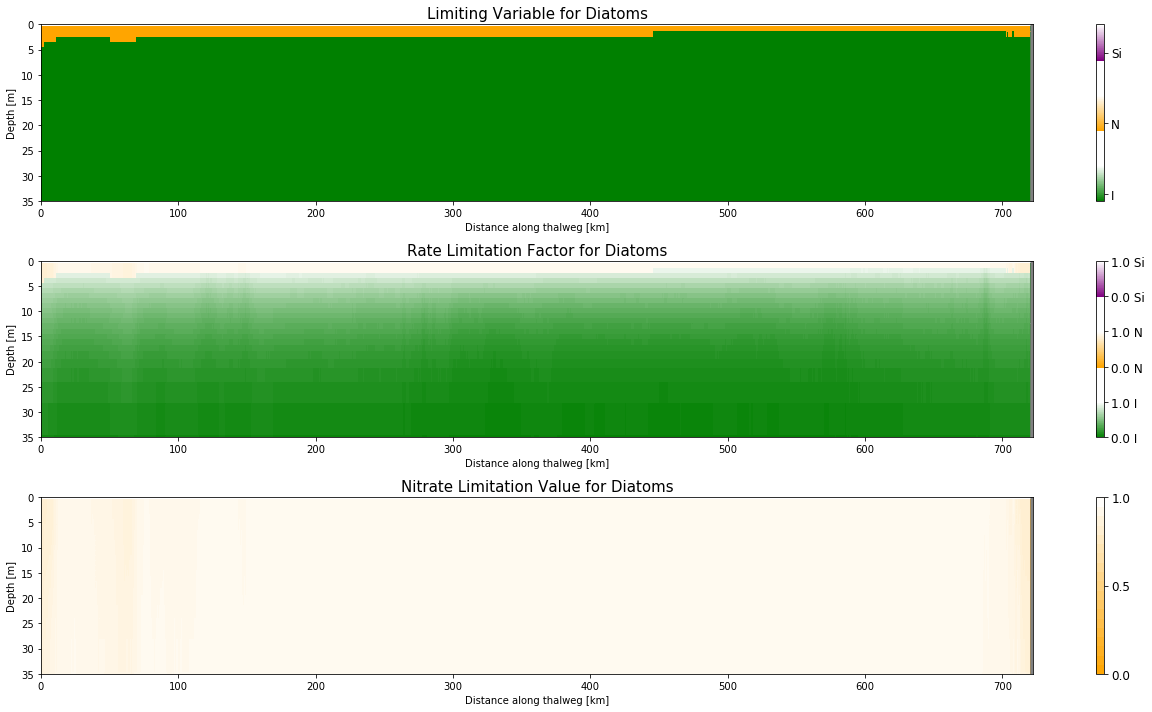

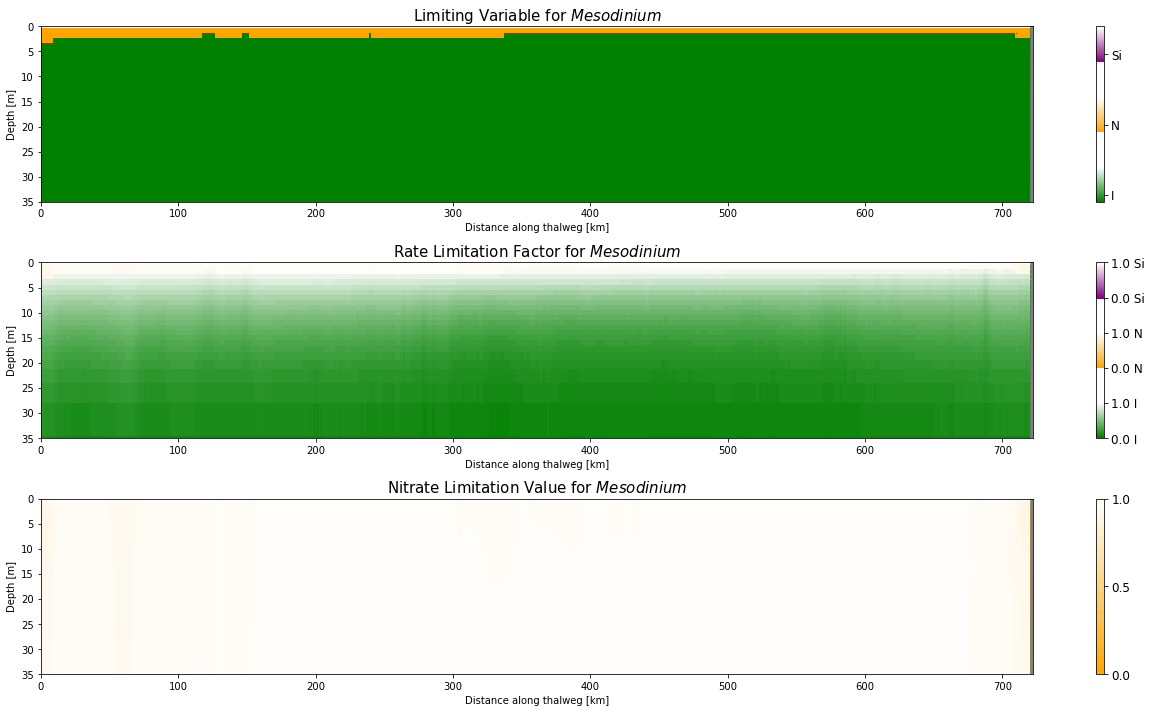

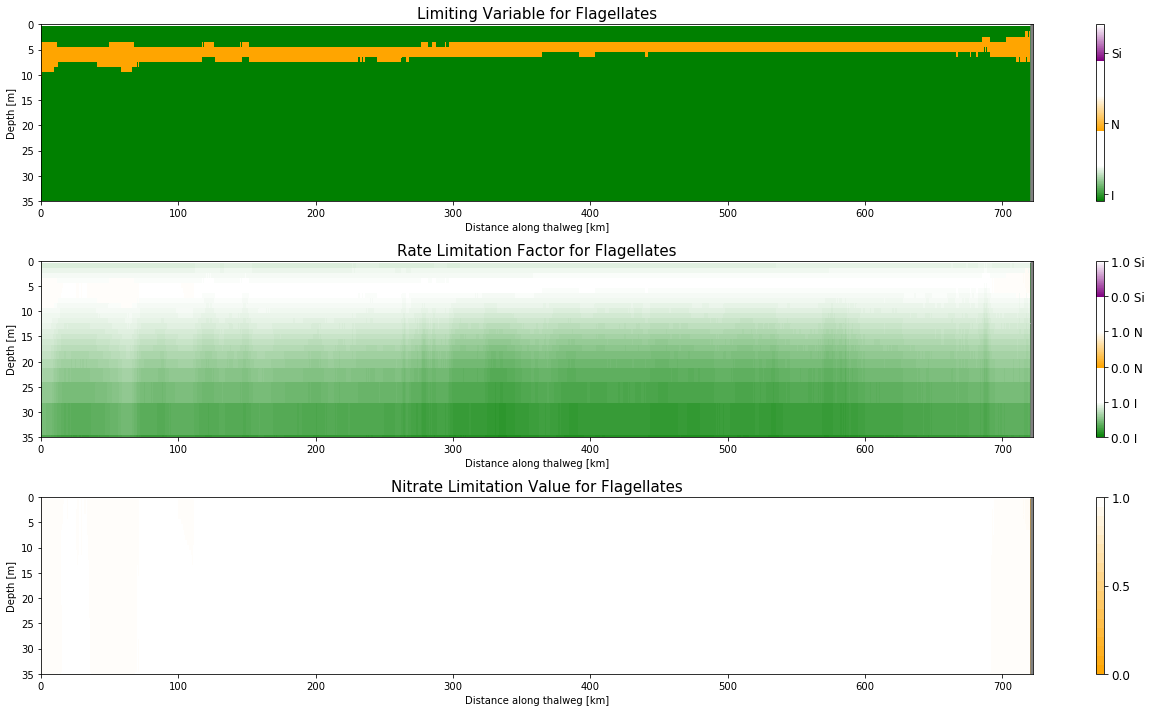

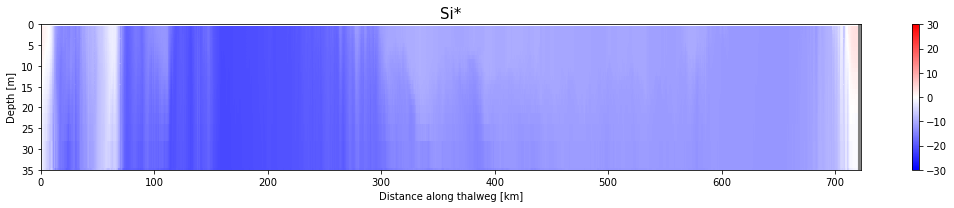

In [96]:
limit_along_thalweg('/results/SalishSea/nowcast-green/28dec14', 
                    'SalishSea_2h_20141228_20150106_dia1_T.nc',
                   'SalishSea_1h_20141228_20141228_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/28dec14', 
                    'SalishSea_2h_20141228_20150106_dia1_T.nc',
                   'SalishSea_1h_20141228_20141228_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/28dec14', 
                    'SalishSea_2h_20141228_20150106_dia1_T.nc',
                   'SalishSea_1h_20141228_20141228_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/28dec14', 
                    'SalishSea_2h_20141228_20150106_dia1_T.nc',
                   'SalishSea_1h_20141228_20141228_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/28dec14/SalishSea_1h_20141228_20141228_ptrc_T.nc'))

# Febuary 2015

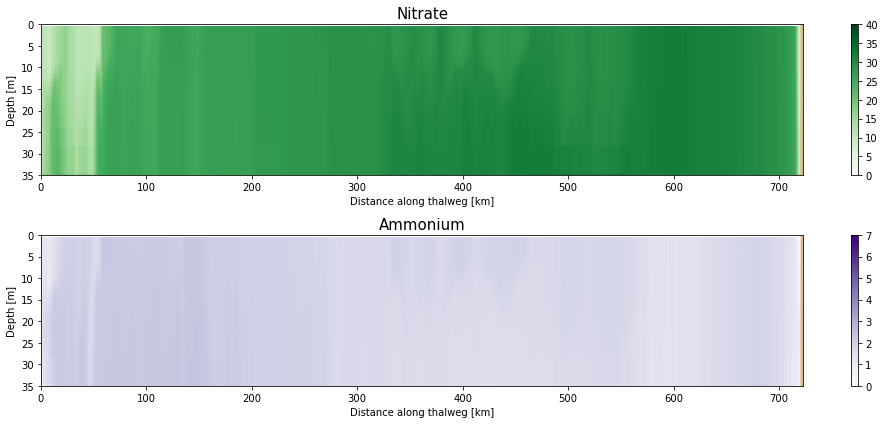

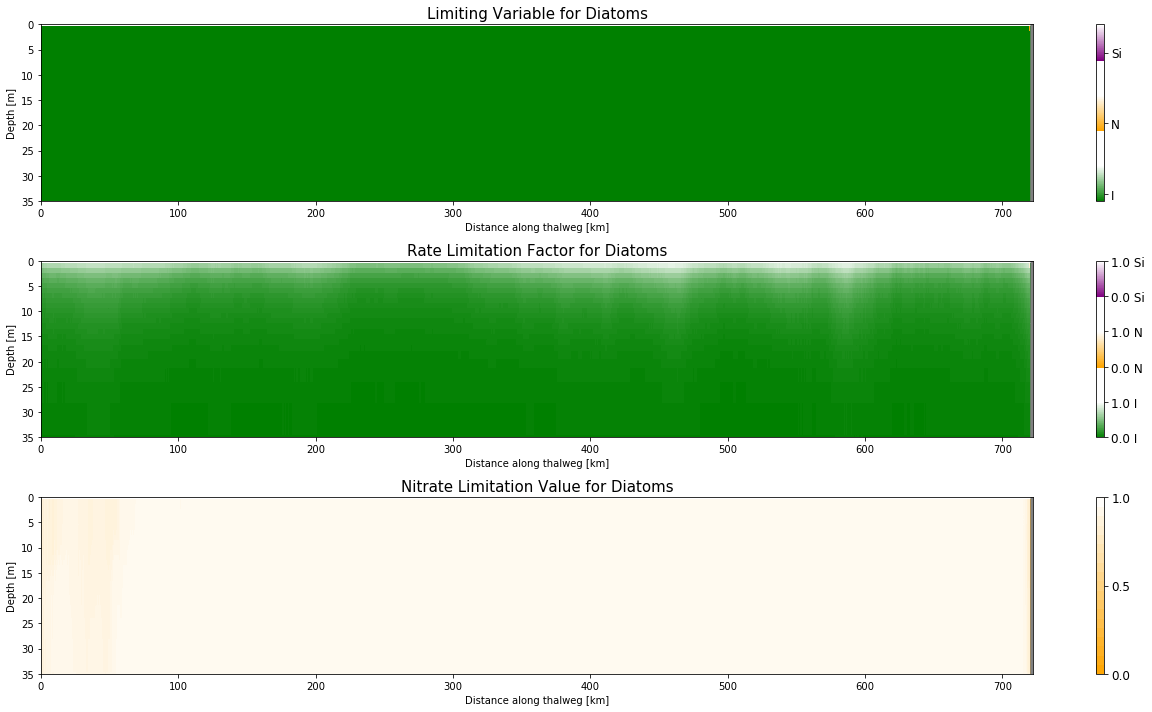

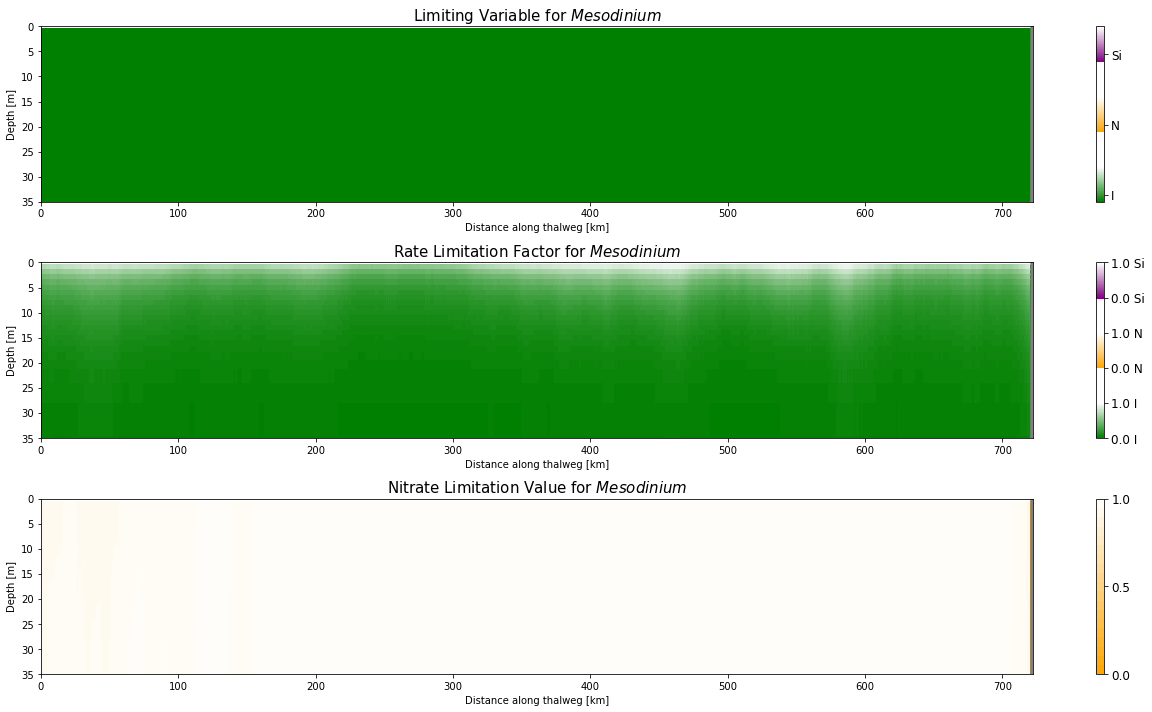

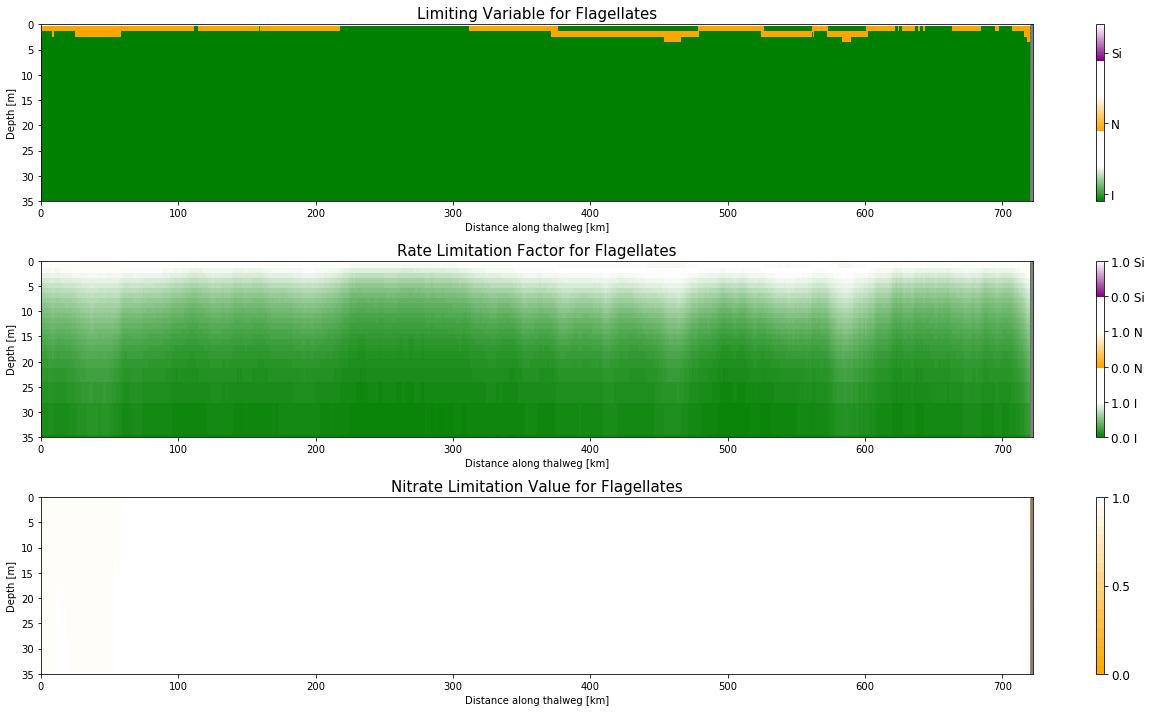

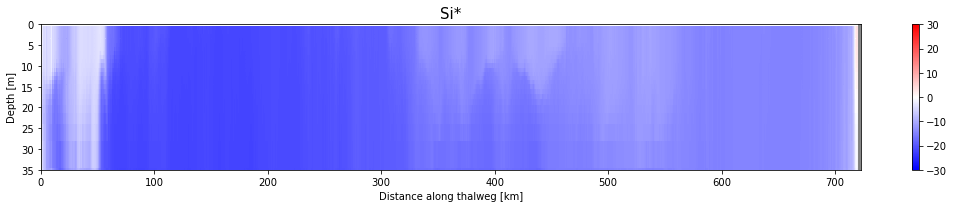

In [97]:
limit_along_thalweg('/results/SalishSea/nowcast-green/06feb15', 
                    'SalishSea_2h_20150206_20150215_dia1_T.nc',
                   'SalishSea_1h_20150206_20150206_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/06feb15', 
                    'SalishSea_2h_20150206_20150215_dia1_T.nc',
                   'SalishSea_1h_20150206_20150206_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/06feb15', 
                    'SalishSea_2h_20150206_20150215_dia1_T.nc',
                   'SalishSea_1h_20150206_20150206_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/06feb15', 
                    'SalishSea_2h_20150206_20150215_dia1_T.nc',
                   'SalishSea_1h_20150206_20150206_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/06feb15/SalishSea_1h_20150206_20150206_ptrc_T.nc'))

# March 2015

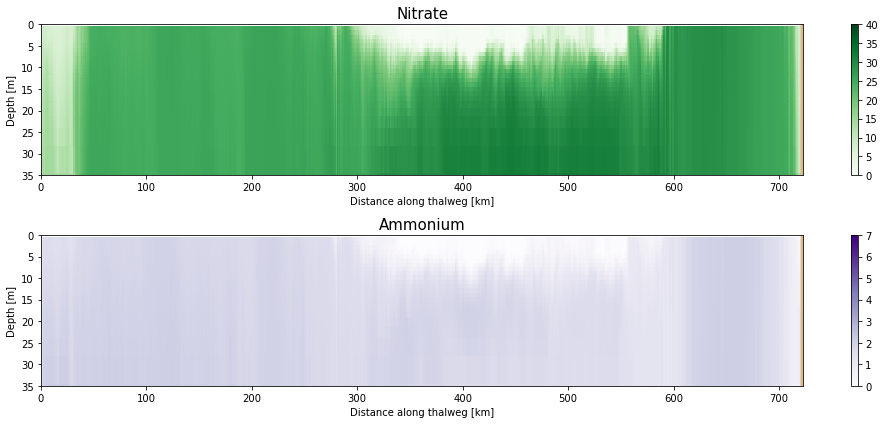

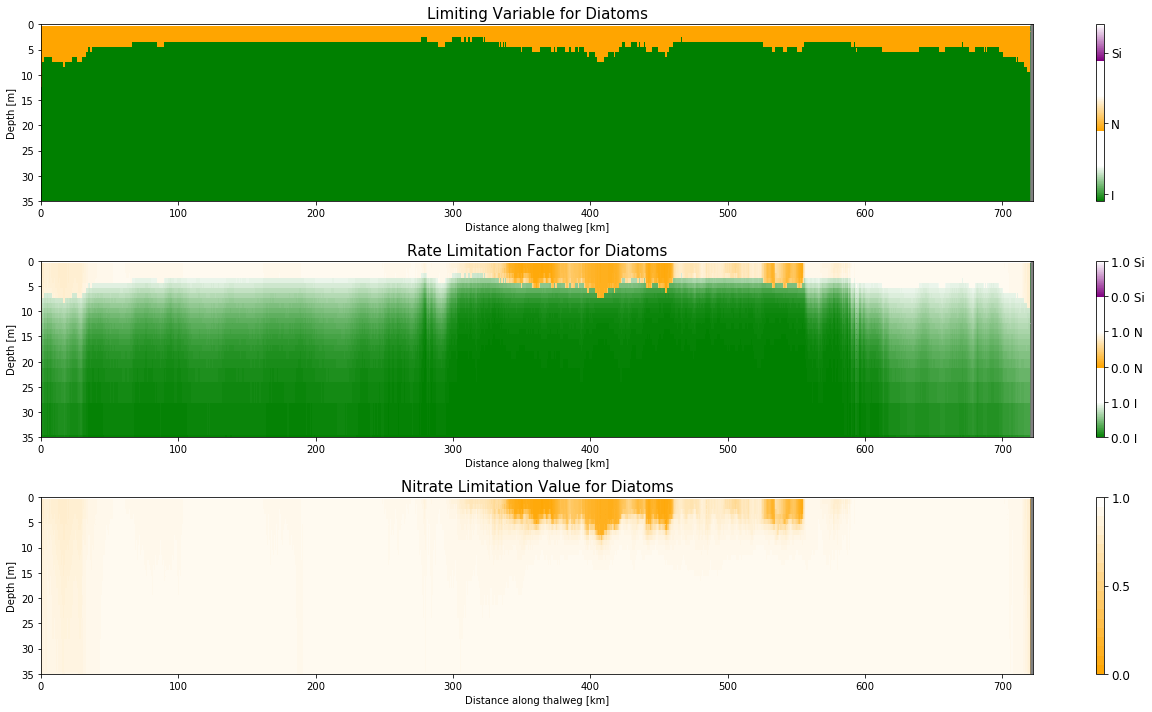

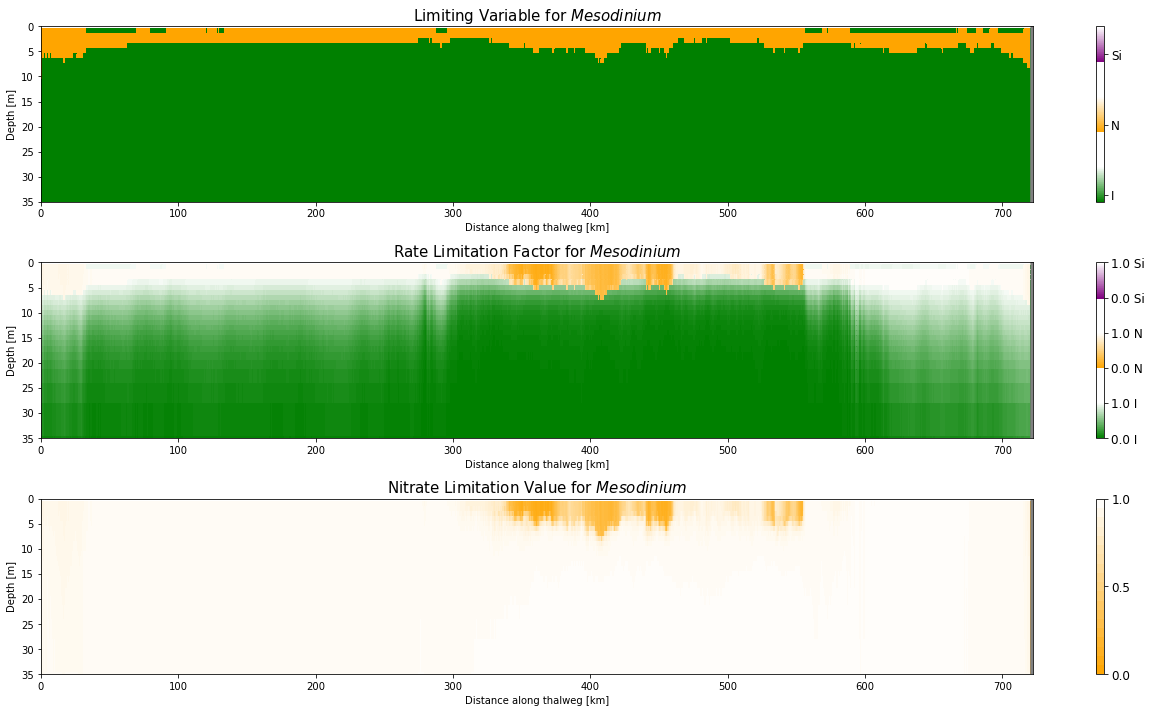

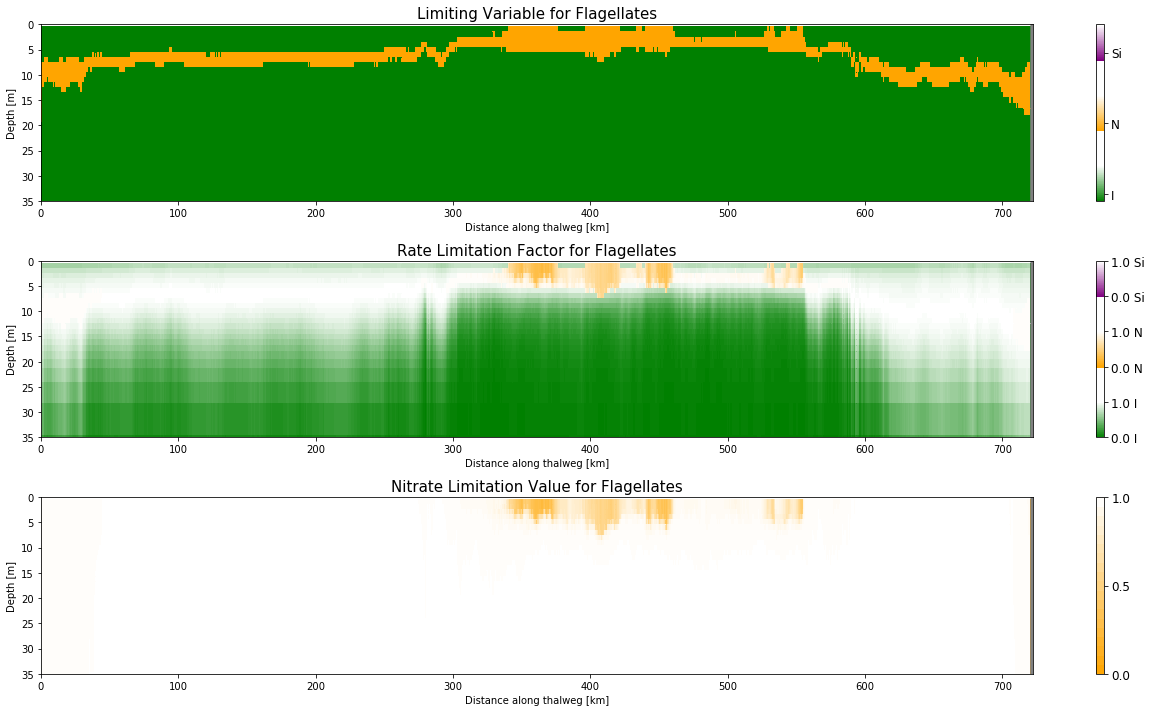

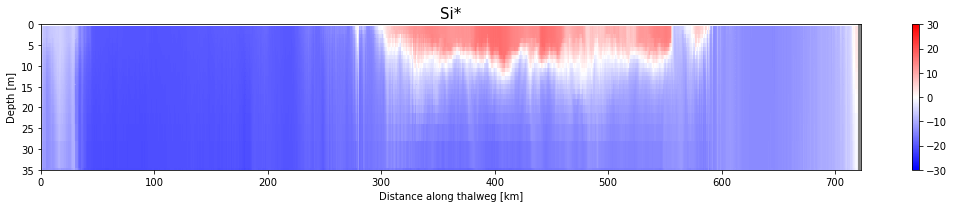

In [98]:
limit_along_thalweg('/results/SalishSea/nowcast-green/08mar15', 
                    'SalishSea_2h_20150308_20150317_dia1_T.nc',
                   'SalishSea_1h_20150308_20150308_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/08mar15', 
                    'SalishSea_2h_20150308_20150317_dia1_T.nc',
                   'SalishSea_1h_20150308_20150308_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/08mar15', 
                    'SalishSea_2h_20150308_20150317_dia1_T.nc',
                   'SalishSea_1h_20150308_20150308_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/08mar15', 
                    'SalishSea_2h_20150308_20150317_dia1_T.nc',
                   'SalishSea_1h_20150308_20150308_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/08mar15/SalishSea_1h_20150308_20150308_ptrc_T.nc'))

# April 2015

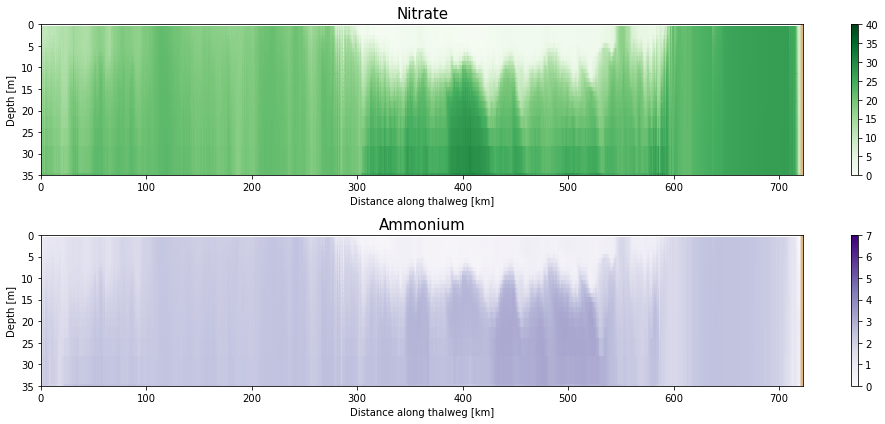

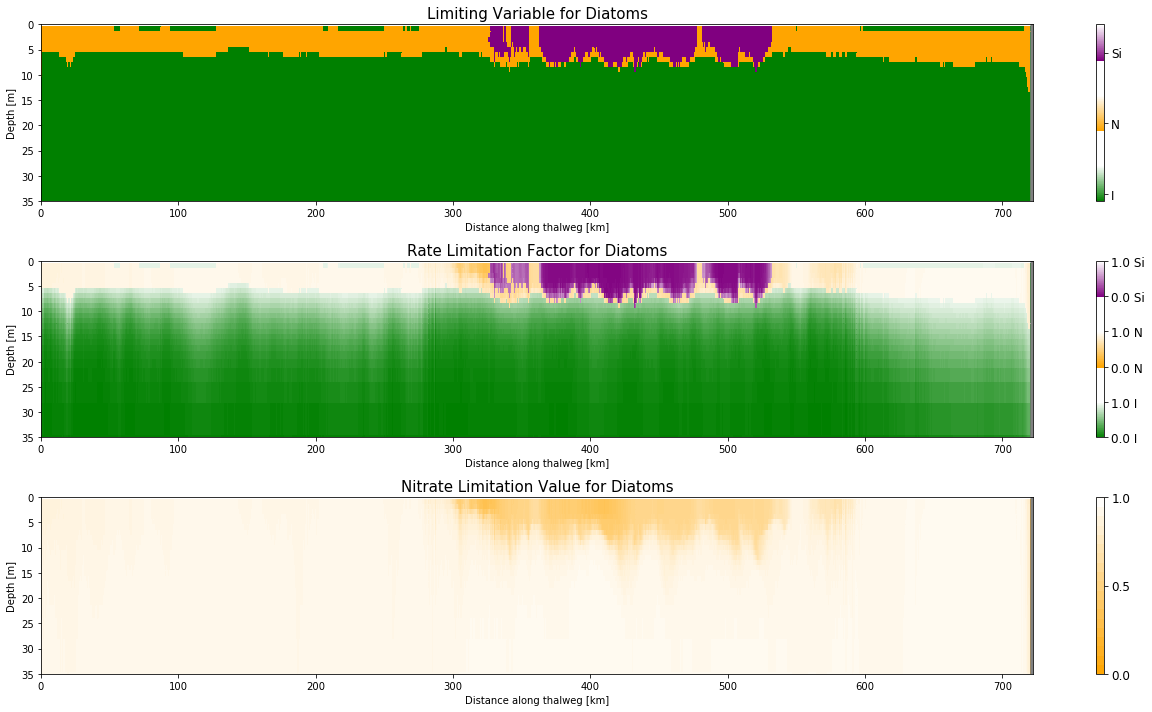

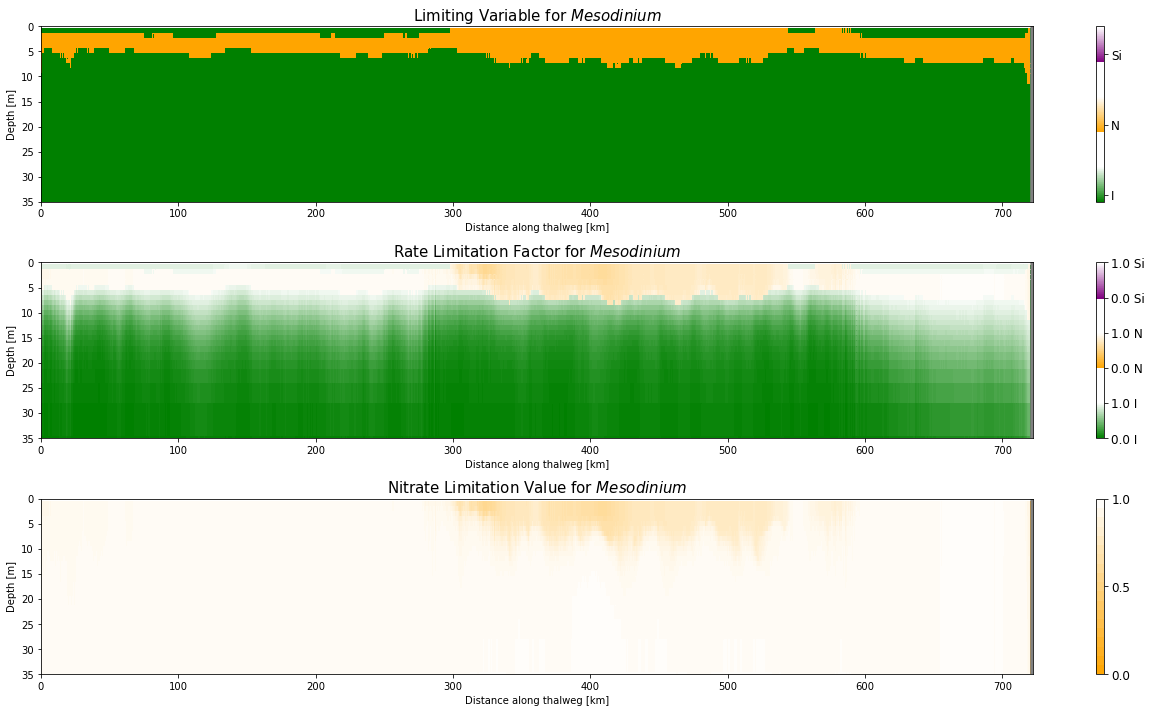

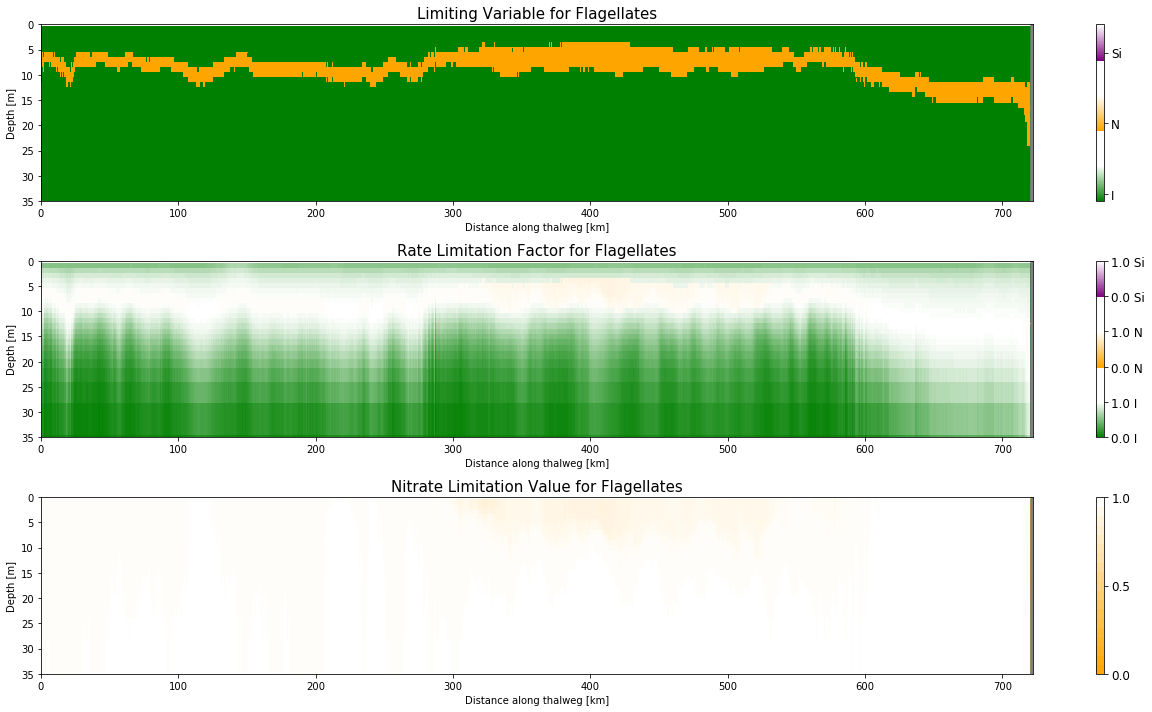

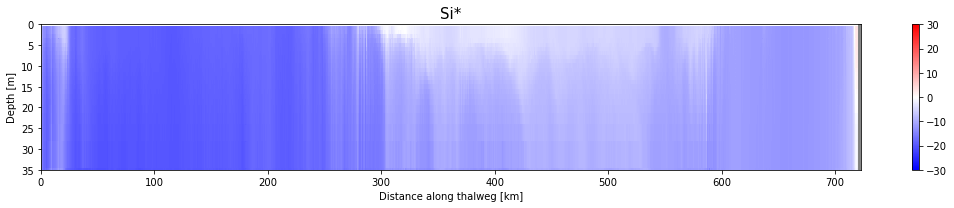

In [99]:
limit_along_thalweg('/results/SalishSea/nowcast-green/07apr15', 
                    'SalishSea_2h_20150407_20150416_dia1_T.nc',
                   'SalishSea_1h_20150407_20150407_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/07apr15', 
                    'SalishSea_2h_20150407_20150416_dia1_T.nc',
                   'SalishSea_1h_20150407_20150407_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/07apr15', 
                    'SalishSea_2h_20150407_20150416_dia1_T.nc',
                   'SalishSea_1h_20150407_20150407_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/07apr15', 
                    'SalishSea_2h_20150407_20150416_dia1_T.nc',
                   'SalishSea_1h_20150407_20150407_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/07apr15/SalishSea_1h_20150407_20150407_ptrc_T.nc'))

# May 2015

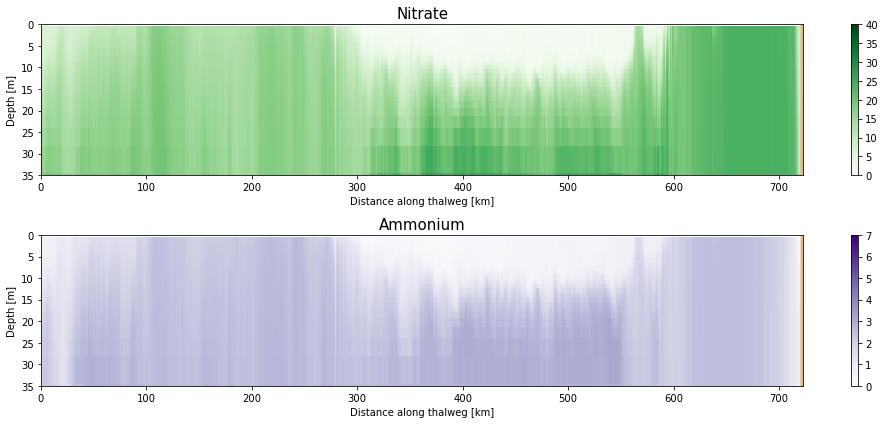

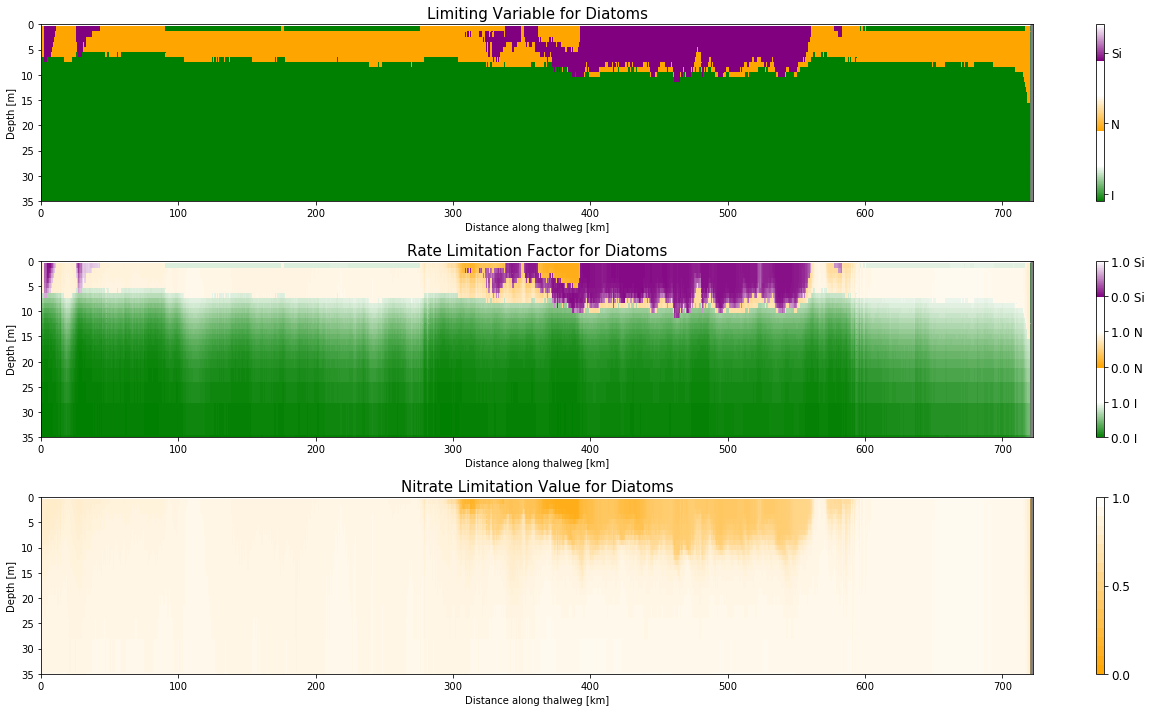

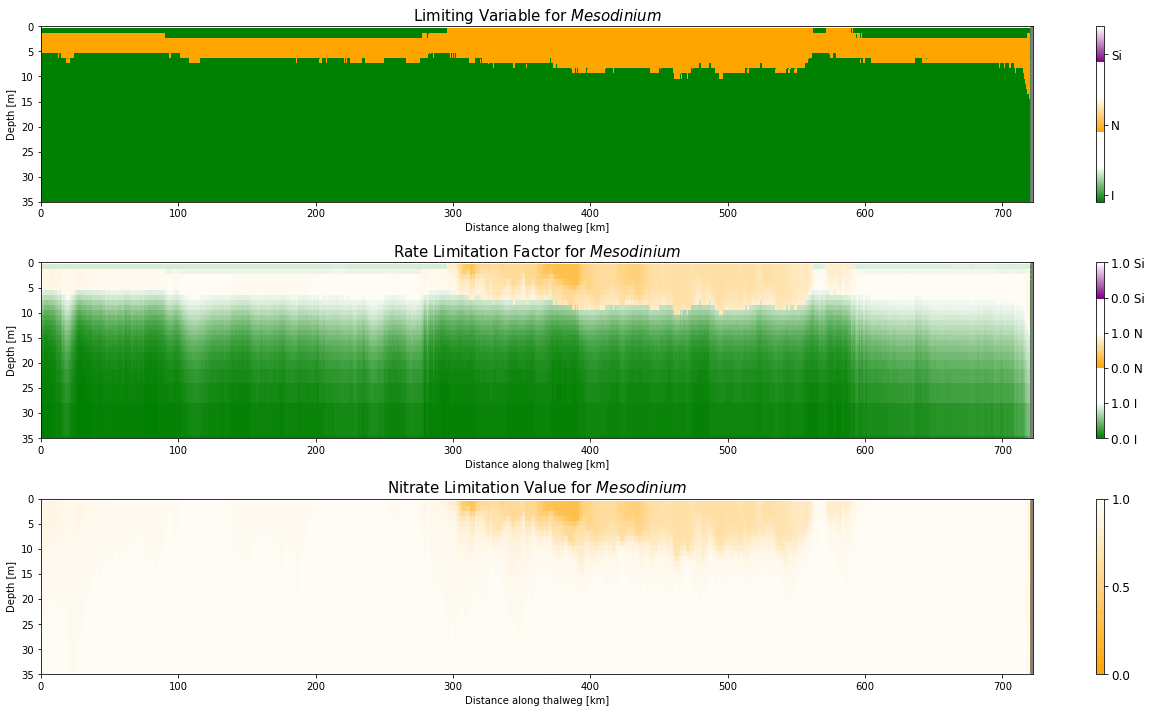

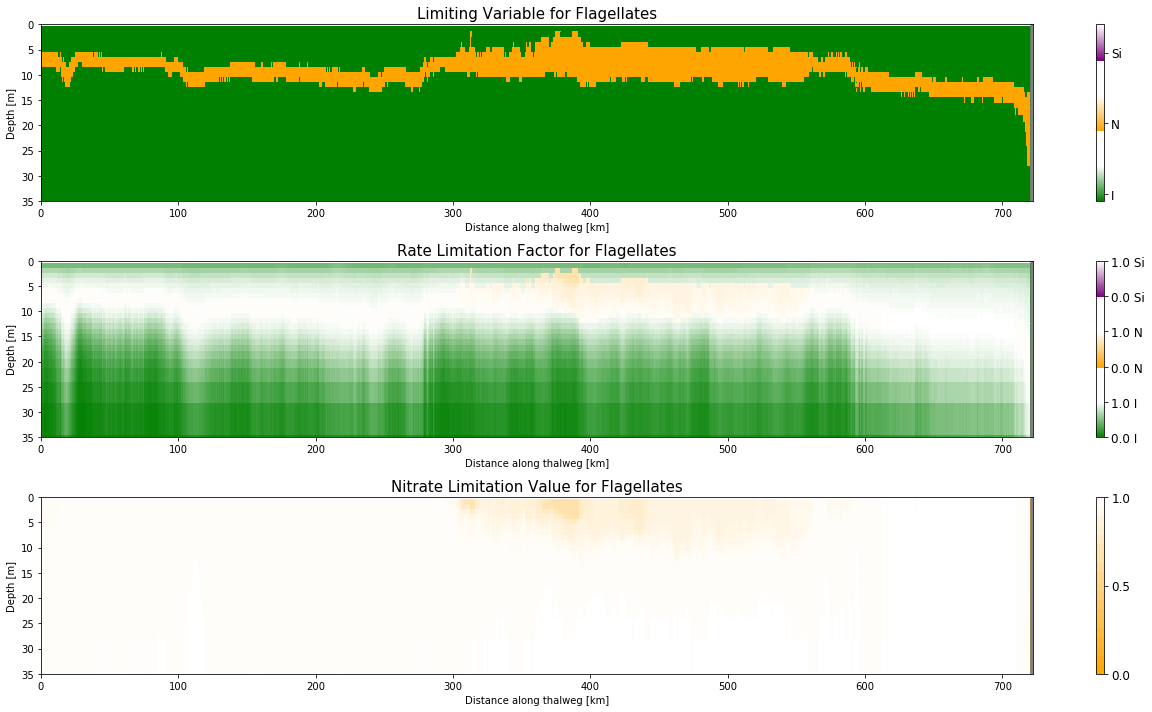

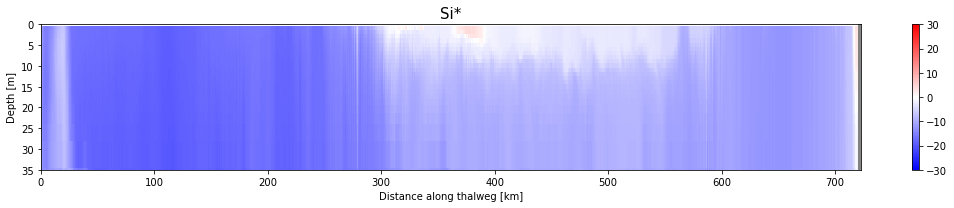

In [100]:
limit_along_thalweg('/results/SalishSea/nowcast-green/07may15', 
                    'SalishSea_2h_20150507_20150516_dia1_T.nc',
                   'SalishSea_1h_20150507_20150507_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/07may15', 
                    'SalishSea_2h_20150507_20150516_dia1_T.nc',
                   'SalishSea_1h_20150507_20150507_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/07may15', 
                    'SalishSea_2h_20150507_20150516_dia1_T.nc',
                   'SalishSea_1h_20150507_20150507_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/07may15', 
                    'SalishSea_2h_20150507_20150516_dia1_T.nc',
                   'SalishSea_1h_20150507_20150507_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/07may15/SalishSea_1h_20150507_20150507_ptrc_T.nc'))

# June 2015

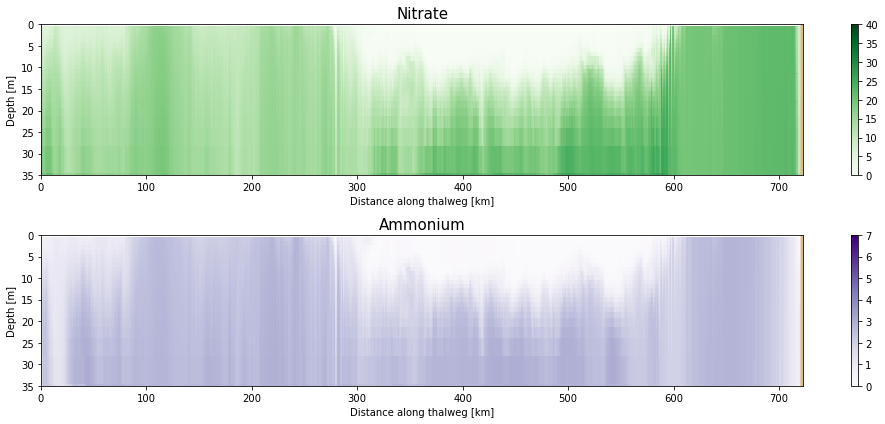

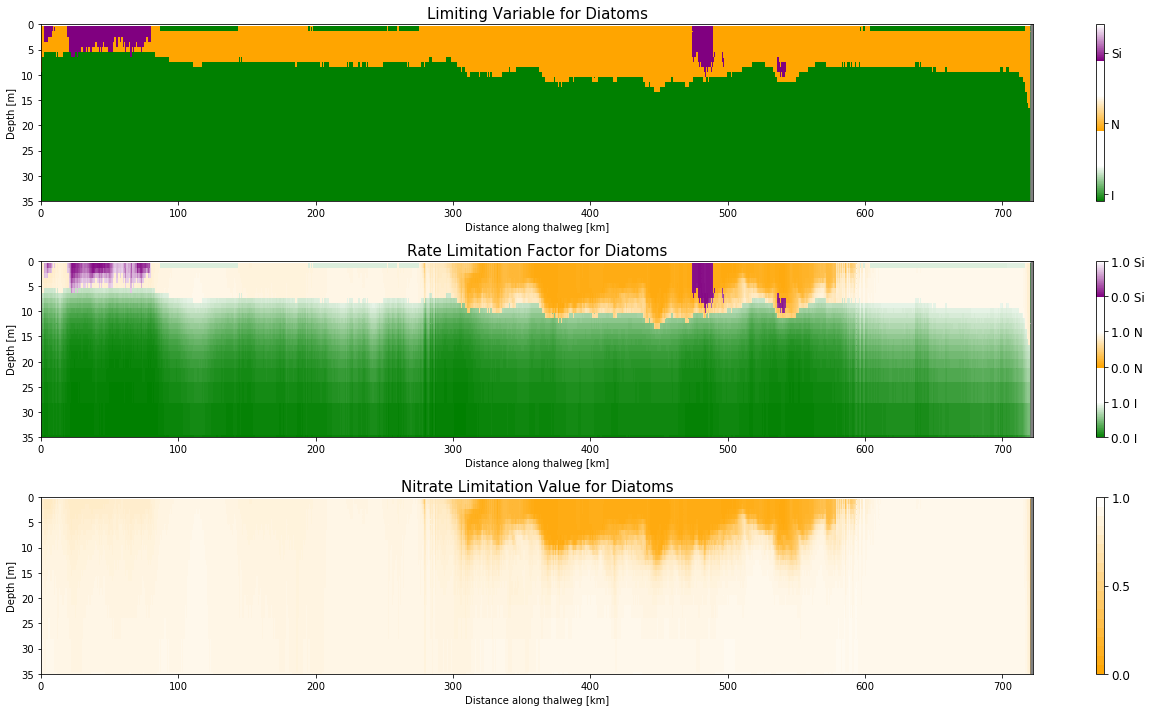

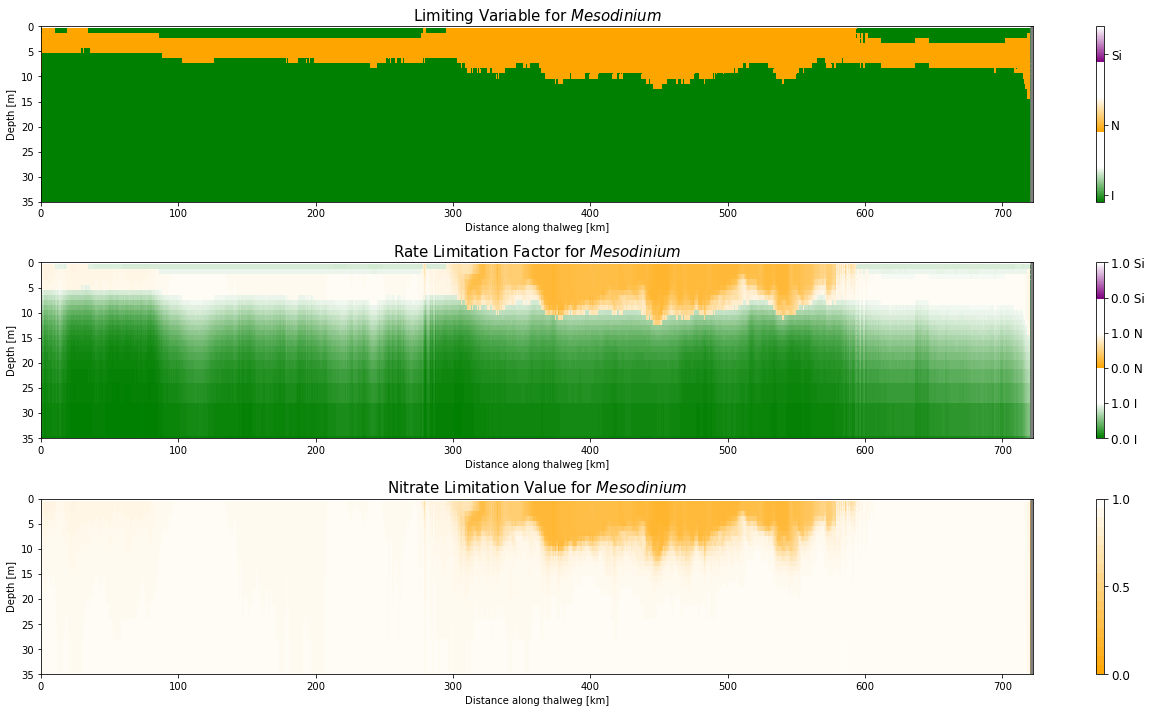

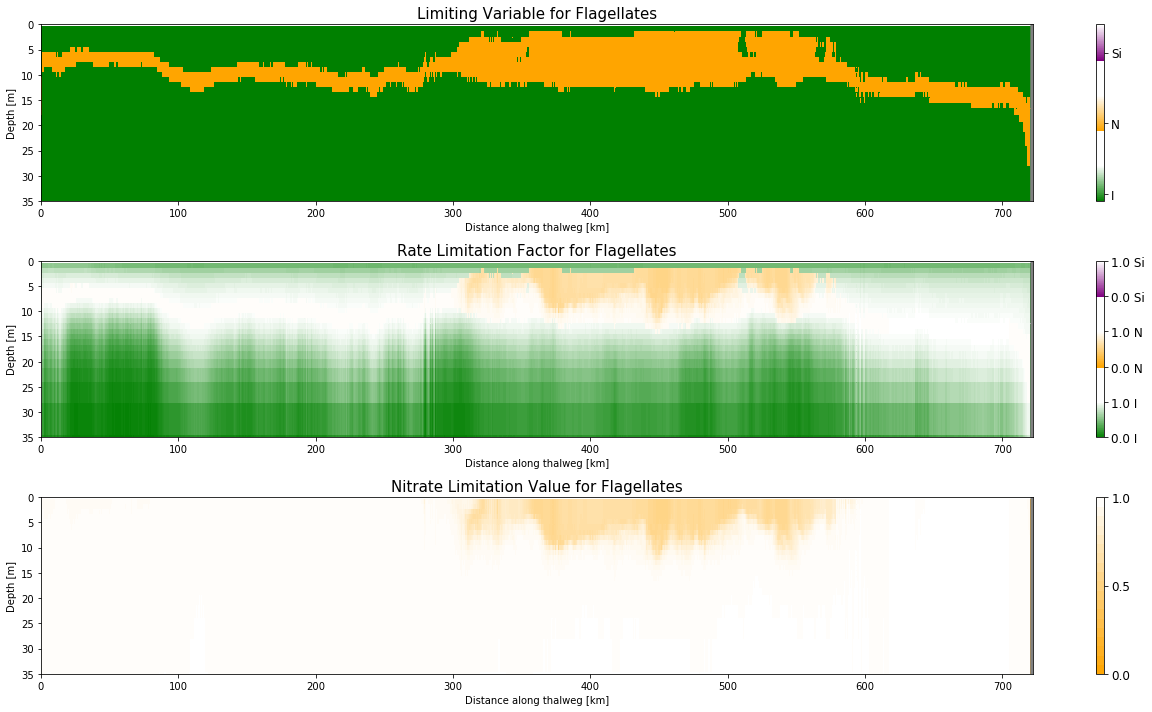

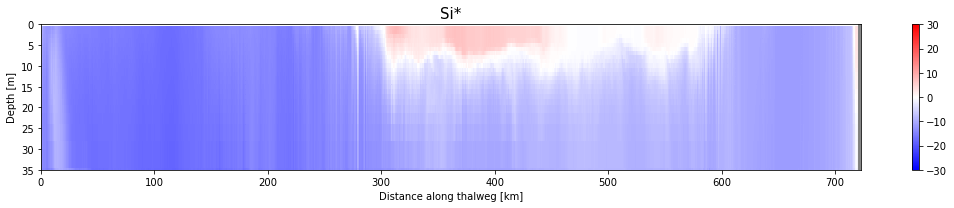

In [101]:
limit_along_thalweg('/results/SalishSea/nowcast-green/06jun15', 
                    'SalishSea_2h_20150606_20150615_dia1_T.nc',
                    'SalishSea_1h_20150606_20150606_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/06jun15', 
                    'SalishSea_2h_20150606_20150615_dia1_T.nc',
                    'SalishSea_1h_20150606_20150606_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/06jun15', 
                    'SalishSea_2h_20150606_20150615_dia1_T.nc',
                    'SalishSea_1h_20150606_20150606_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/06jun15', 
                    'SalishSea_2h_20150606_20150615_dia1_T.nc',
                    'SalishSea_1h_20150606_20150606_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/06jun15/SalishSea_1h_20150606_20150606_ptrc_T.nc'))

# July 2015

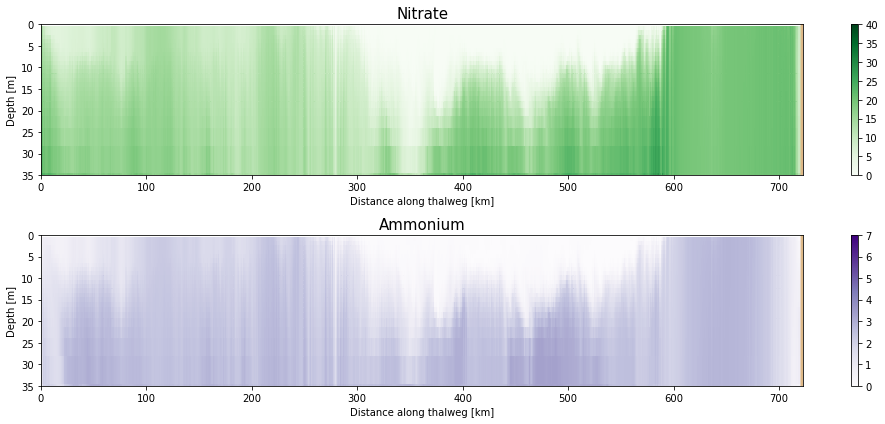

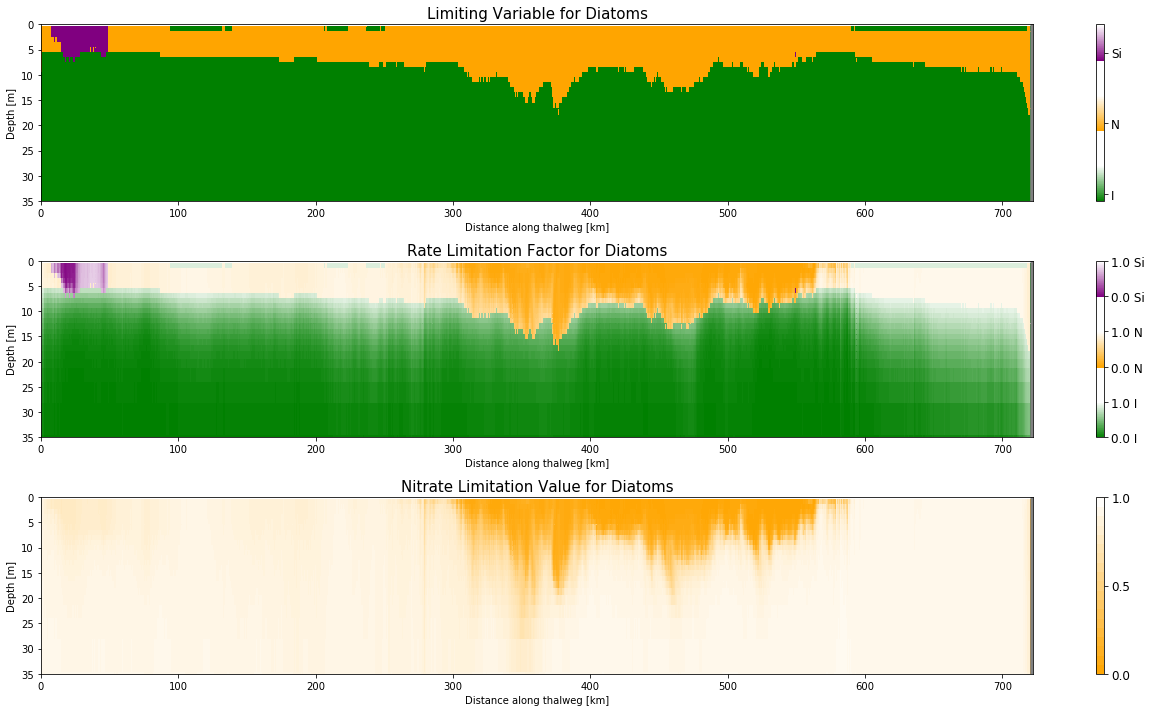

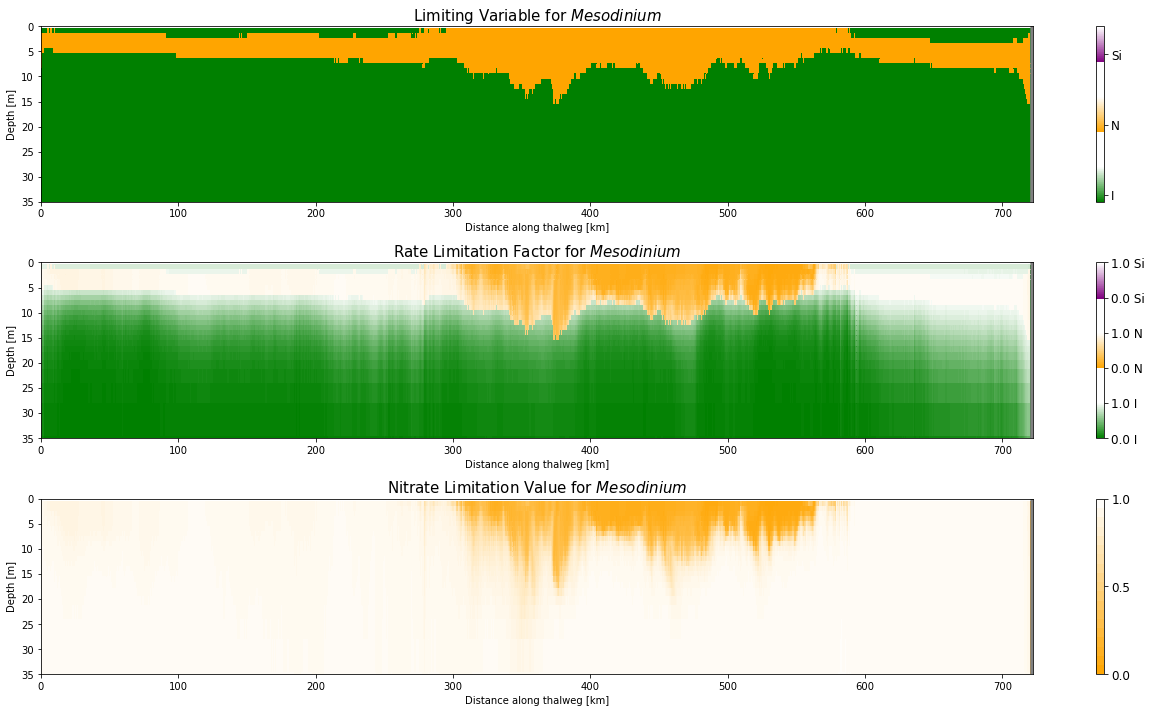

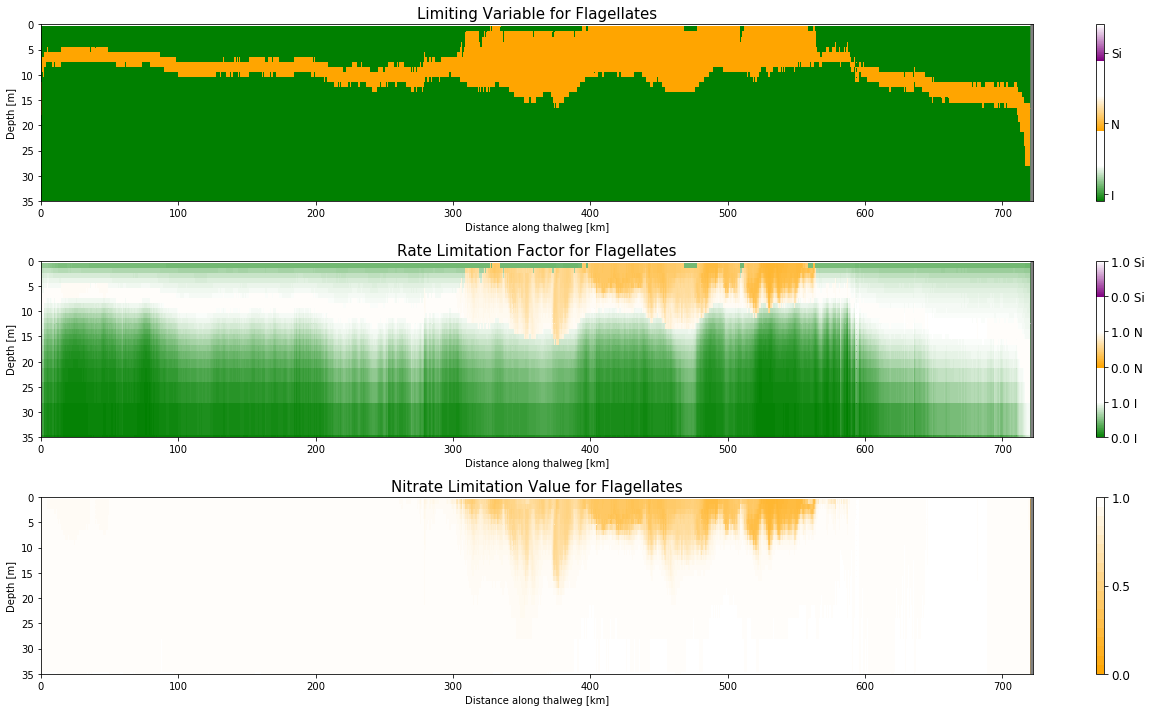

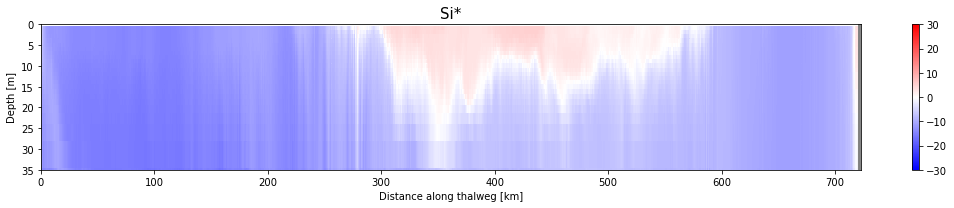

In [102]:
limit_along_thalweg('/results/SalishSea/nowcast-green/06jul15', 
                    'SalishSea_2h_20150706_20150715_dia1_T.nc',
                    'SalishSea_1h_20150706_20150706_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/06jul15', 
                    'SalishSea_2h_20150706_20150715_dia1_T.nc',
                    'SalishSea_1h_20150706_20150706_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/06jul15', 
                    'SalishSea_2h_20150706_20150715_dia1_T.nc',
                    'SalishSea_1h_20150706_20150706_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/06jul15', 
                    'SalishSea_2h_20150706_20150715_dia1_T.nc',
                    'SalishSea_1h_20150706_20150706_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/06jul15/SalishSea_1h_20150706_20150706_ptrc_T.nc'))

# August 2015

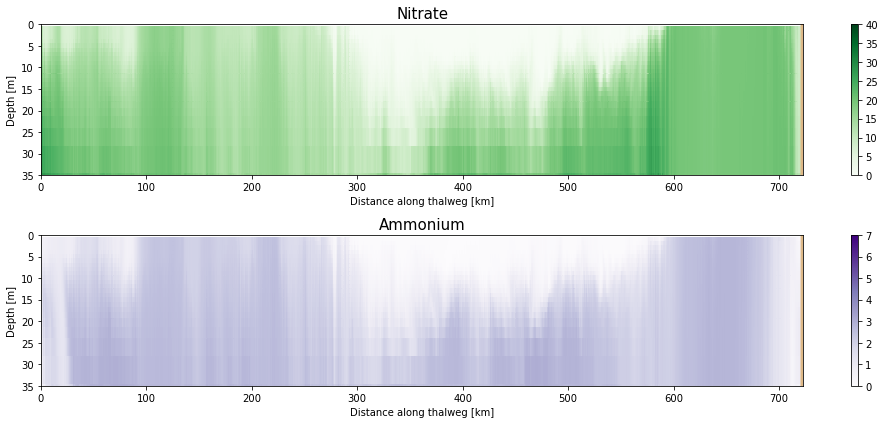

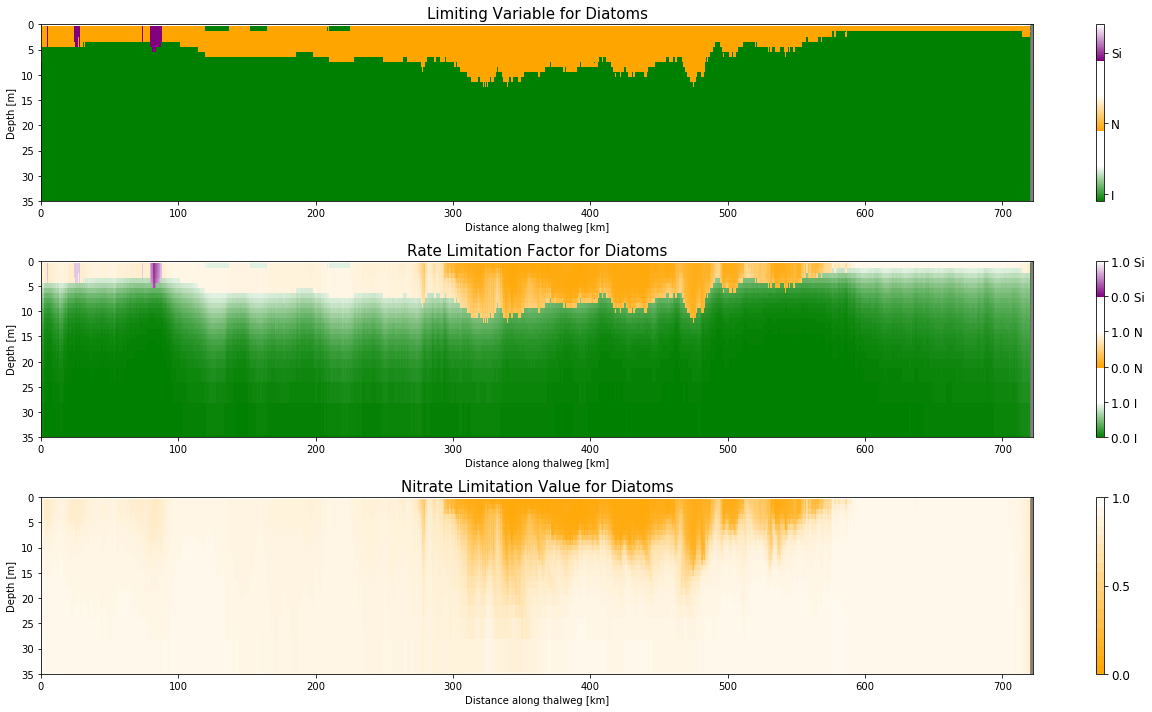

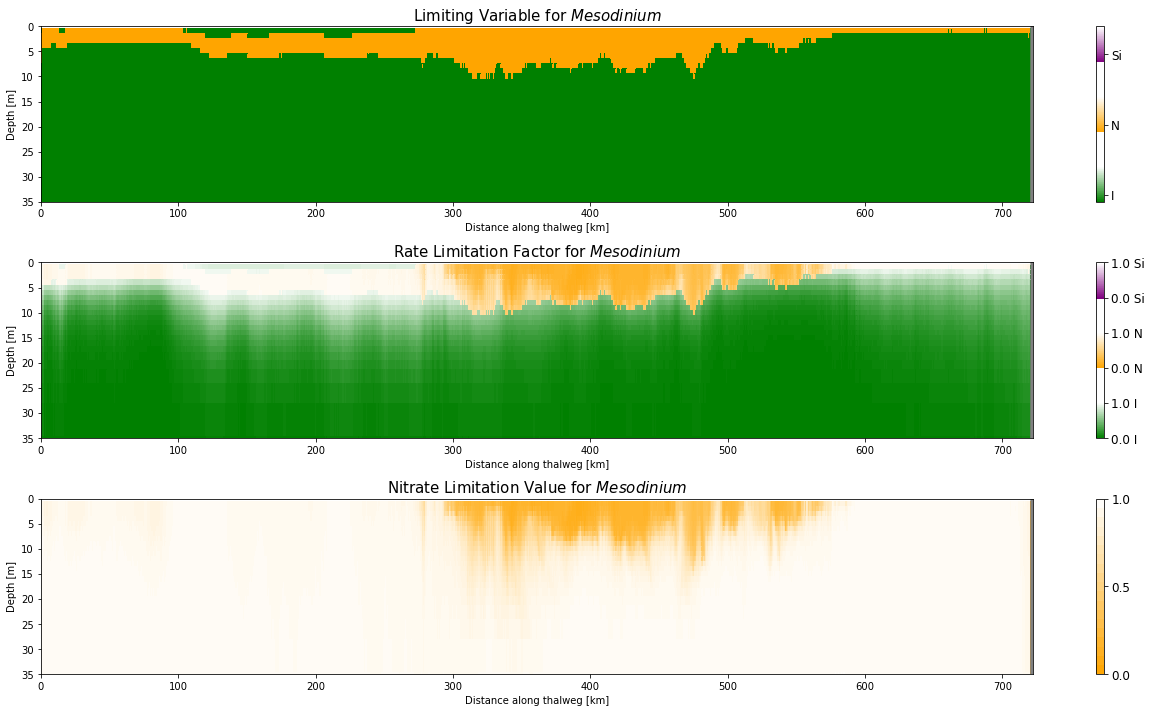

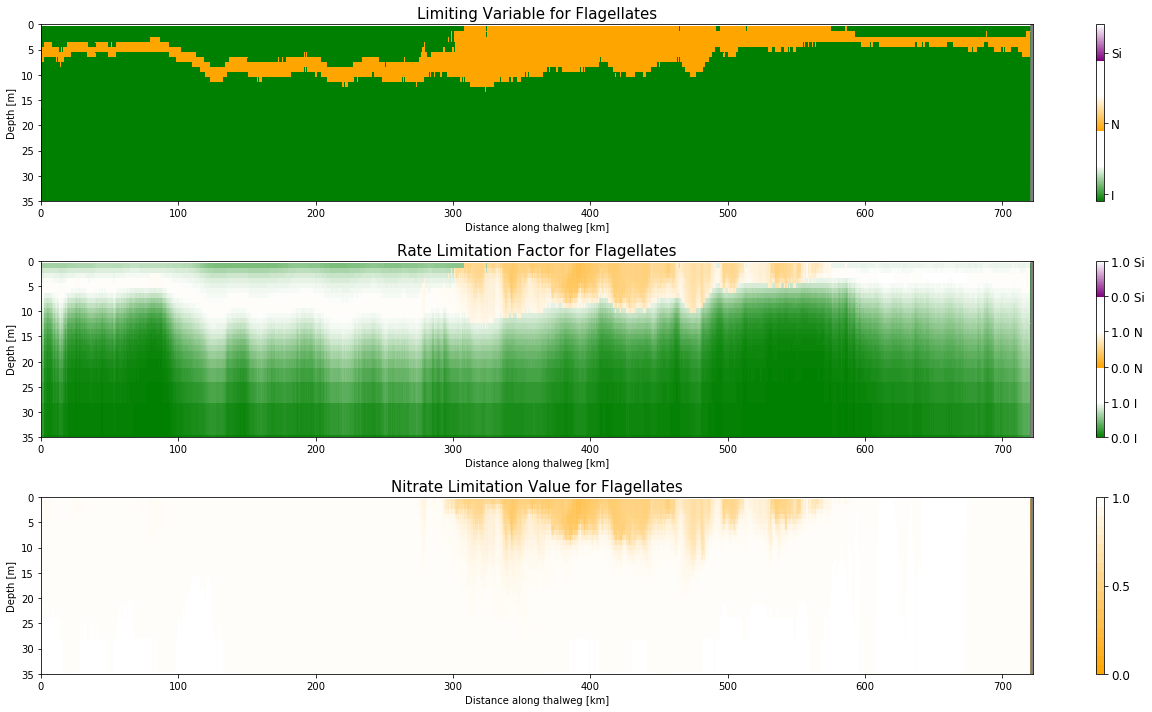

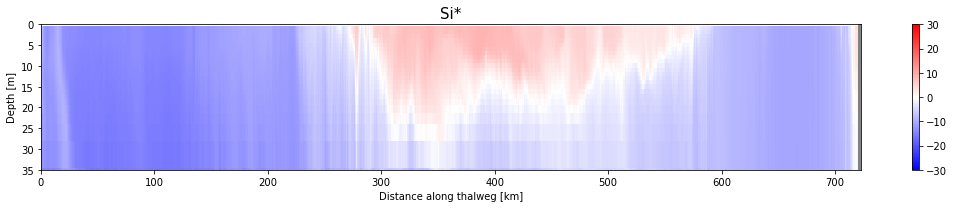

In [103]:
limit_along_thalweg('/results/SalishSea/nowcast-green/05aug15', 
                    'SalishSea_2h_20150805_20150814_dia1_T.nc',
                    'SalishSea_1h_20150805_20150805_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/05aug15', 
                    'SalishSea_2h_20150805_20150814_dia1_T.nc',
                    'SalishSea_1h_20150805_20150805_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/05aug15', 
                    'SalishSea_2h_20150805_20150814_dia1_T.nc',
                    'SalishSea_1h_20150805_20150805_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/05aug15', 
                    'SalishSea_2h_20150805_20150814_dia1_T.nc',
                    'SalishSea_1h_20150805_20150805_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/05aug15/SalishSea_1h_20150805_20150805_ptrc_T.nc'))

# September 2015

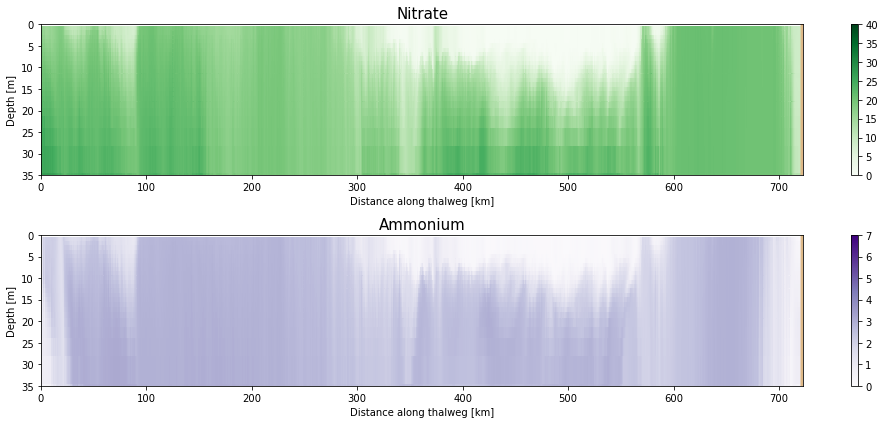

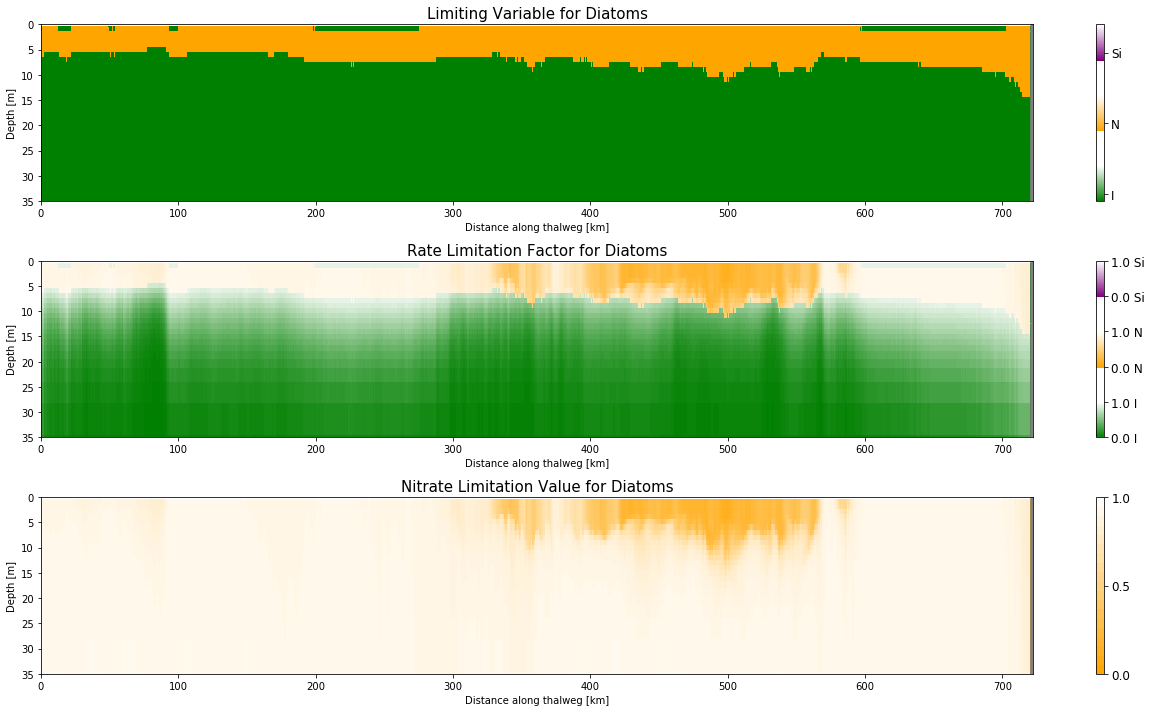

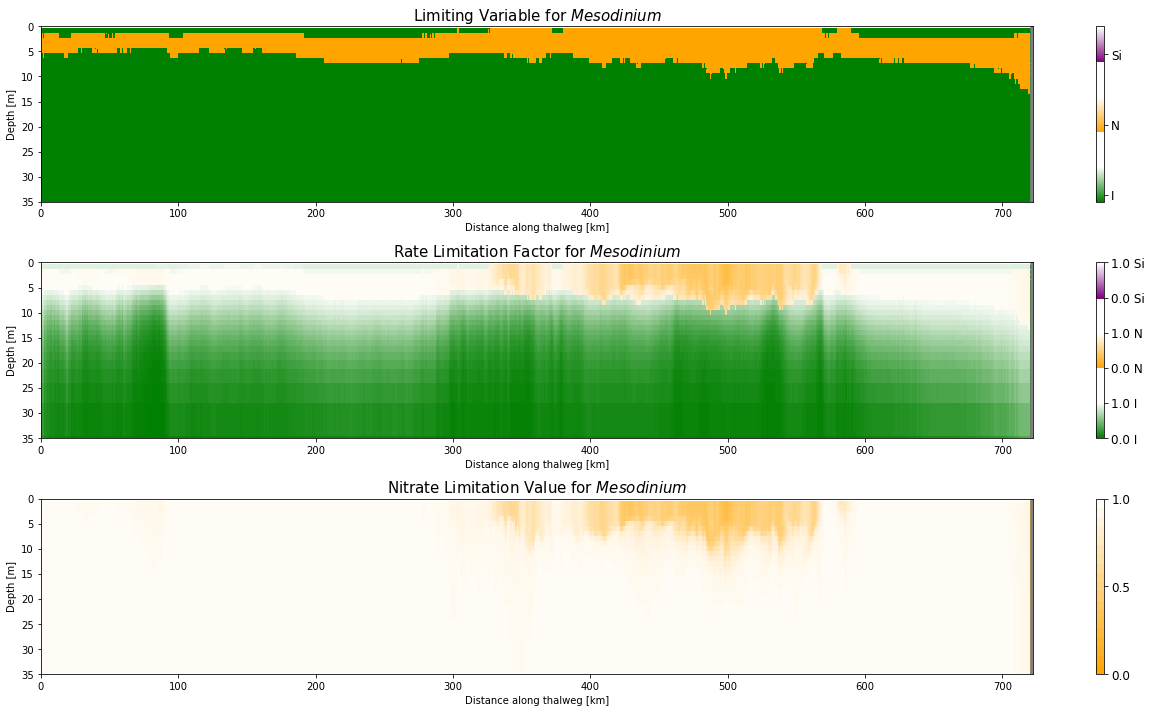

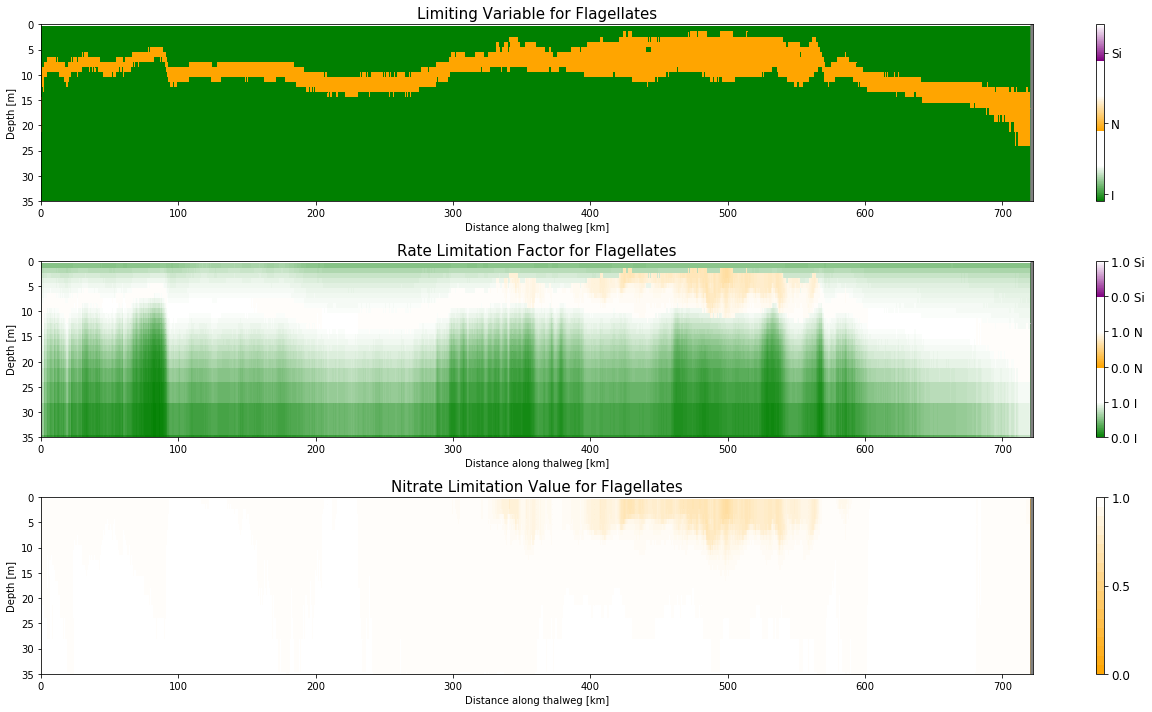

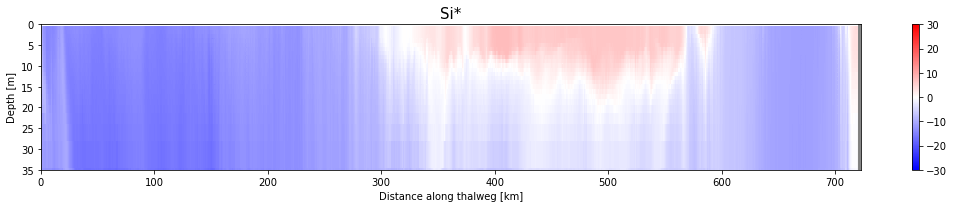

In [104]:
limit_along_thalweg('/results/SalishSea/nowcast-green/04sep15', 
                    'SalishSea_2h_20150904_20150913_dia1_T.nc',
                    'SalishSea_1h_20150904_20150904_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/04sep15', 
                    'SalishSea_2h_20150904_20150913_dia1_T.nc',
                    'SalishSea_1h_20150904_20150904_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/04sep15', 
                    'SalishSea_2h_20150904_20150913_dia1_T.nc',
                    'SalishSea_1h_20150904_20150904_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/04sep15', 
                    'SalishSea_2h_20150904_20150913_dia1_T.nc',
                    'SalishSea_1h_20150904_20150904_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/04sep15/SalishSea_1h_20150904_20150904_ptrc_T.nc'))

# October 2015

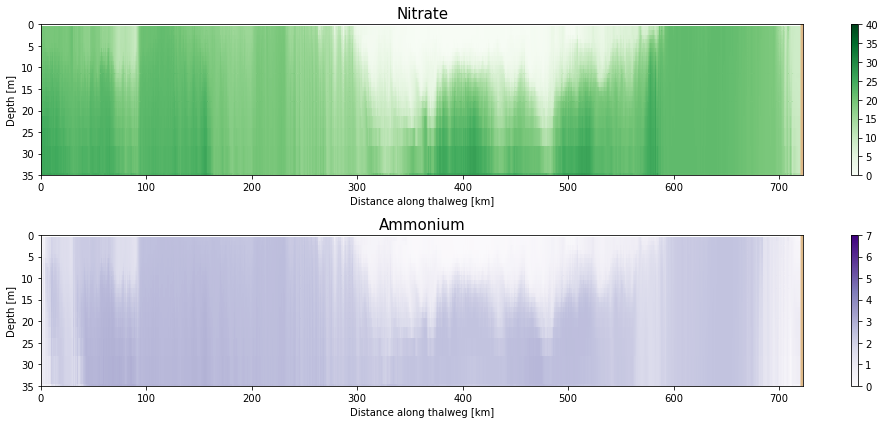

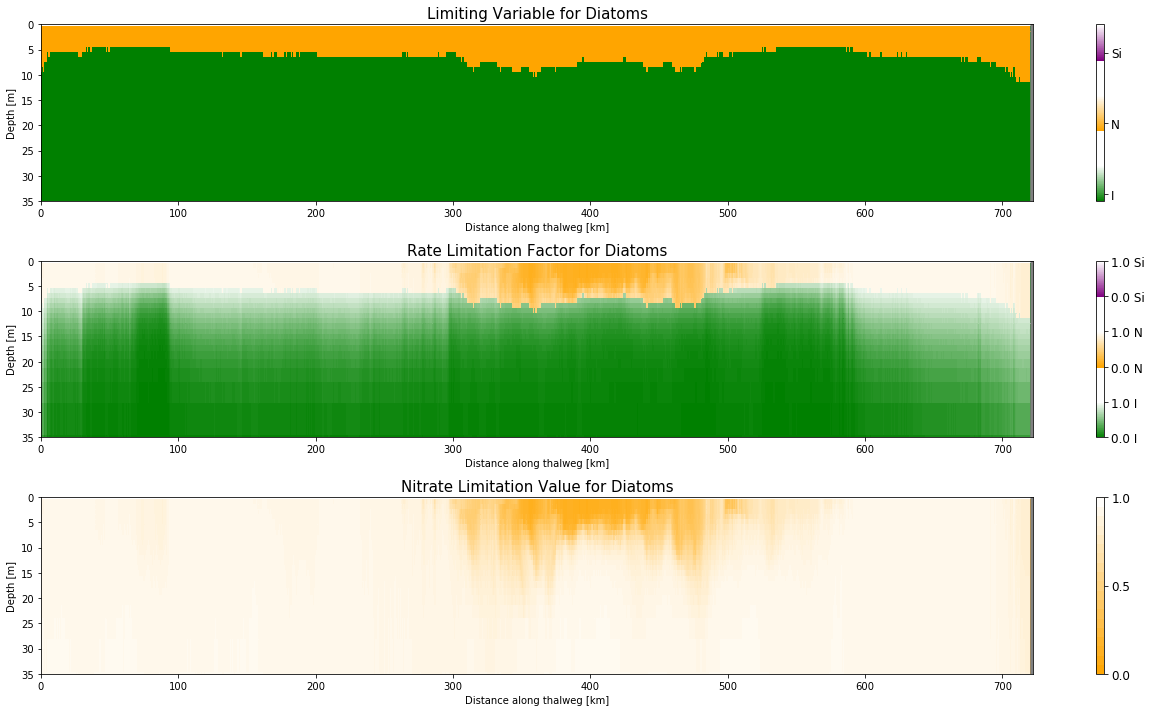

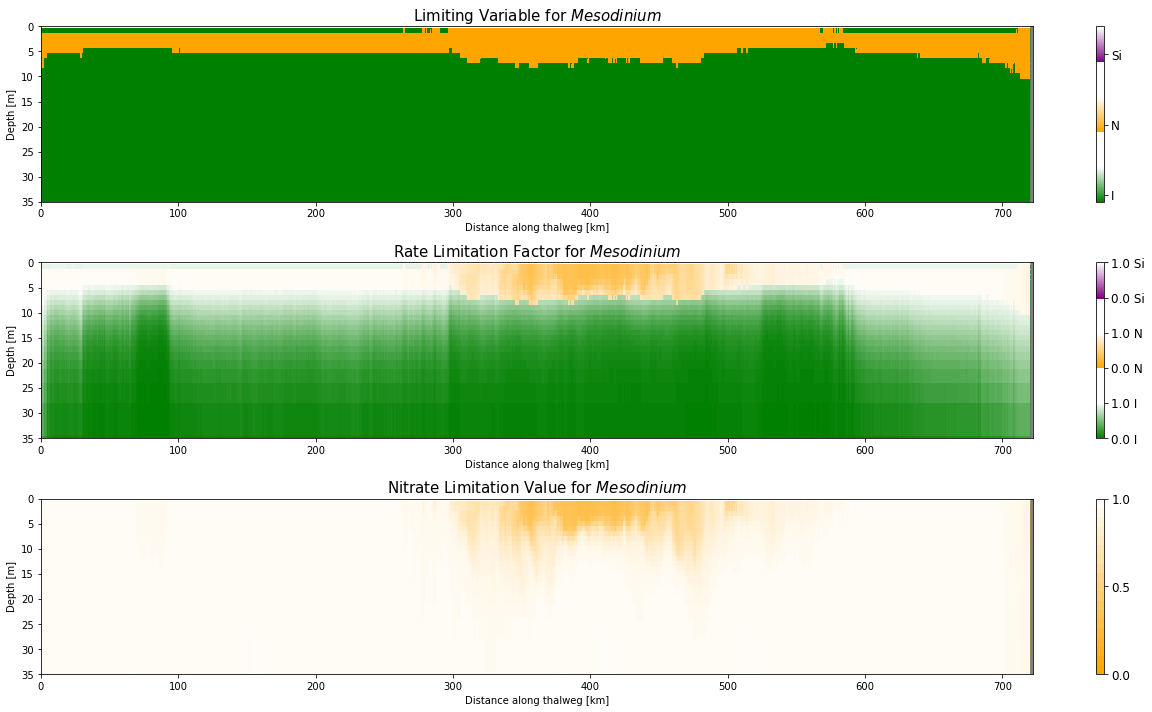

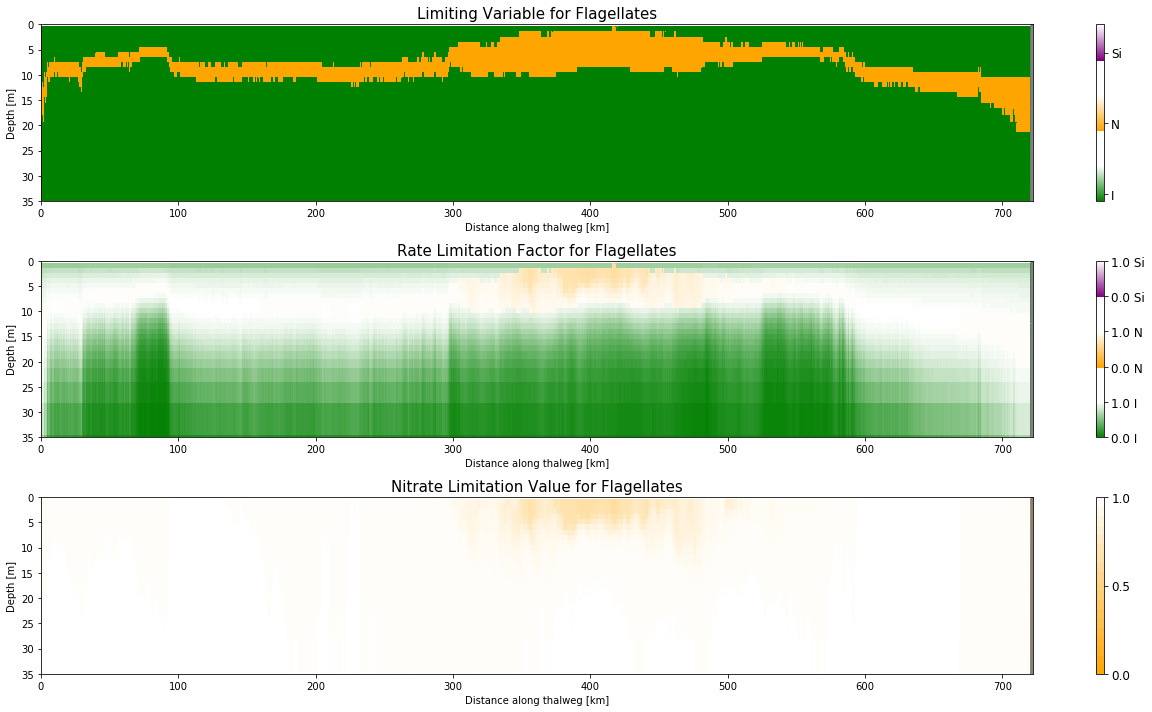

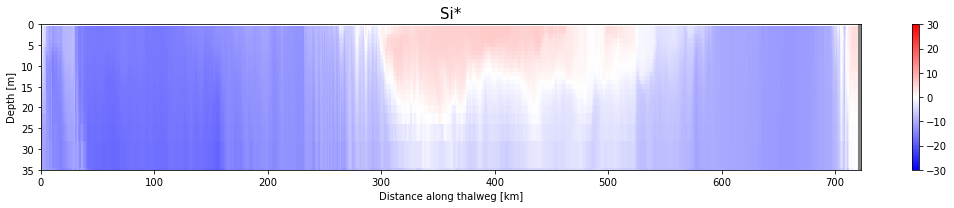

In [105]:
limit_along_thalweg('/results/SalishSea/nowcast-green/04oct15', 
                    'SalishSea_2h_20151004_20151013_dia1_T.nc',
                    'SalishSea_1h_20151004_20151004_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/04oct15', 
                    'SalishSea_2h_20151004_20151013_dia1_T.nc',
                    'SalishSea_1h_20151004_20151004_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/04oct15', 
                    'SalishSea_2h_20151004_20151013_dia1_T.nc',
                    'SalishSea_1h_20151004_20151004_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/04oct15', 
                    'SalishSea_2h_20151004_20151013_dia1_T.nc',
                    'SalishSea_1h_20151004_20151004_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/04oct15/SalishSea_1h_20151004_20151004_ptrc_T.nc'))

# November 2015

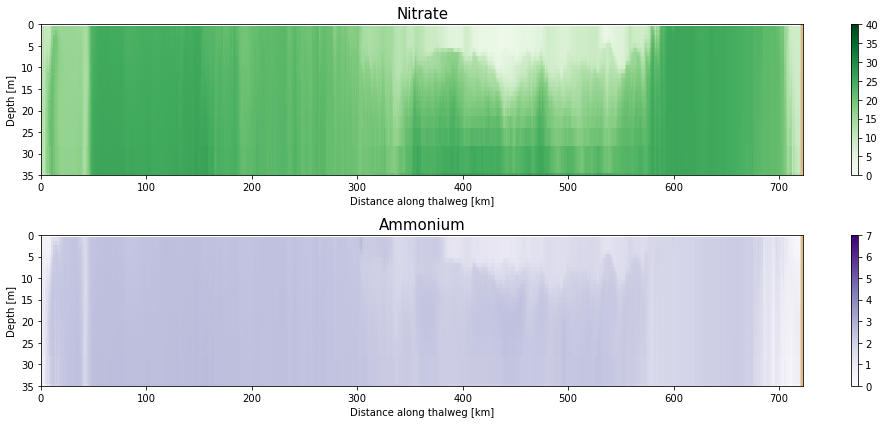

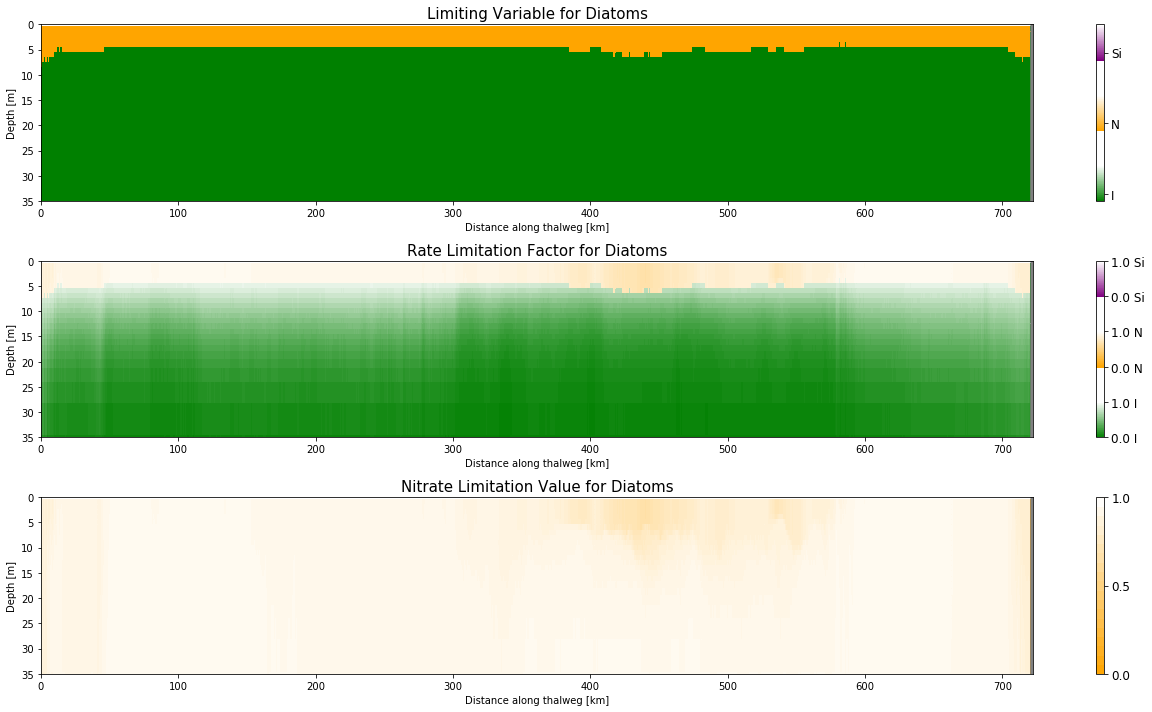

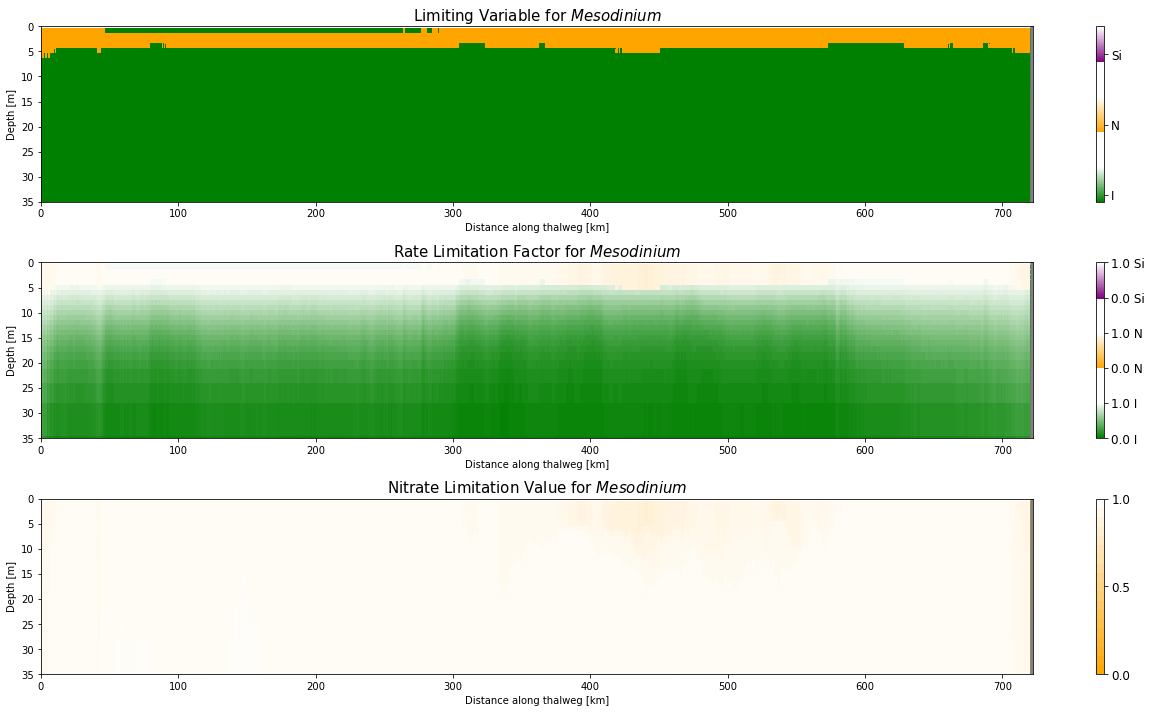

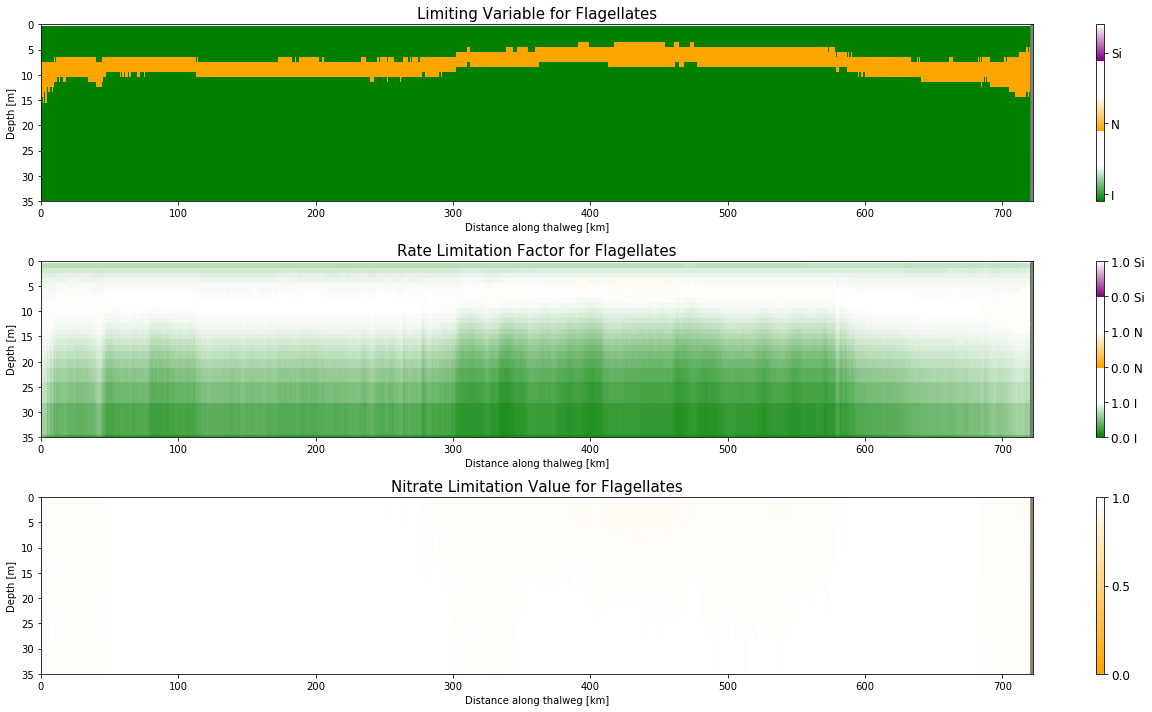

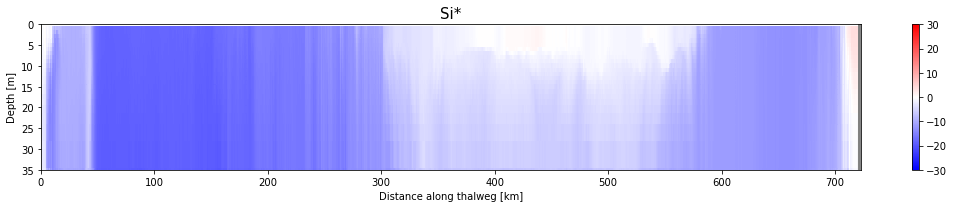

In [106]:
limit_along_thalweg('/results/SalishSea/nowcast-green/03nov15', 
                    'SalishSea_2h_20151103_20151112_dia1_T.nc',
                    'SalishSea_1h_20151103_20151103_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/03nov15', 
                    'SalishSea_2h_20151103_20151112_dia1_T.nc',
                    'SalishSea_1h_20151103_20151103_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/03nov15', 
                    'SalishSea_2h_20151103_20151112_dia1_T.nc',
                    'SalishSea_1h_20151103_20151103_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/03nov15', 
                    'SalishSea_2h_20151103_20151112_dia1_T.nc',
                    'SalishSea_1h_20151103_20151103_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/03nov15/SalishSea_1h_20151103_20151103_ptrc_T.nc'))

# December 2015

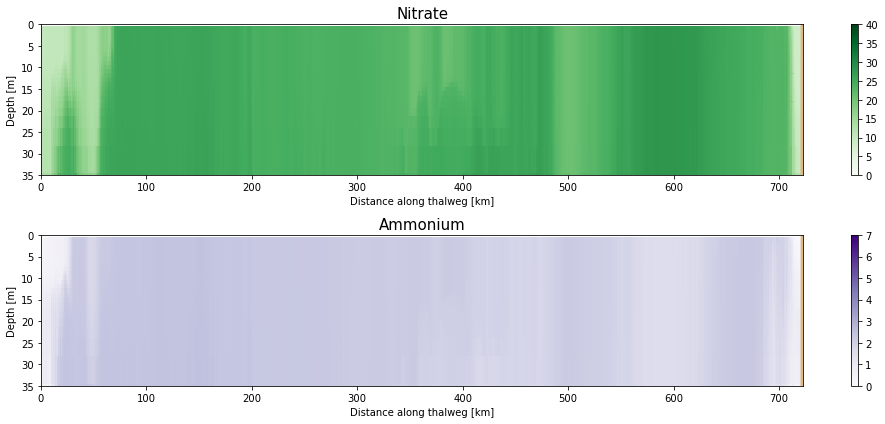

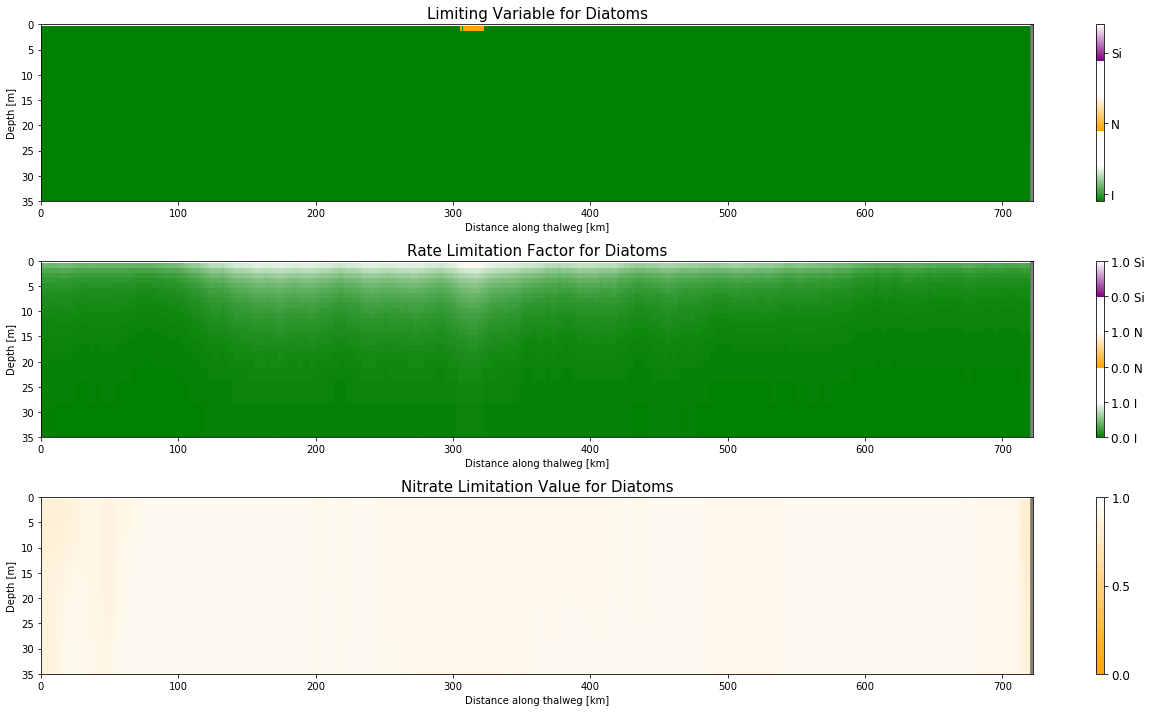

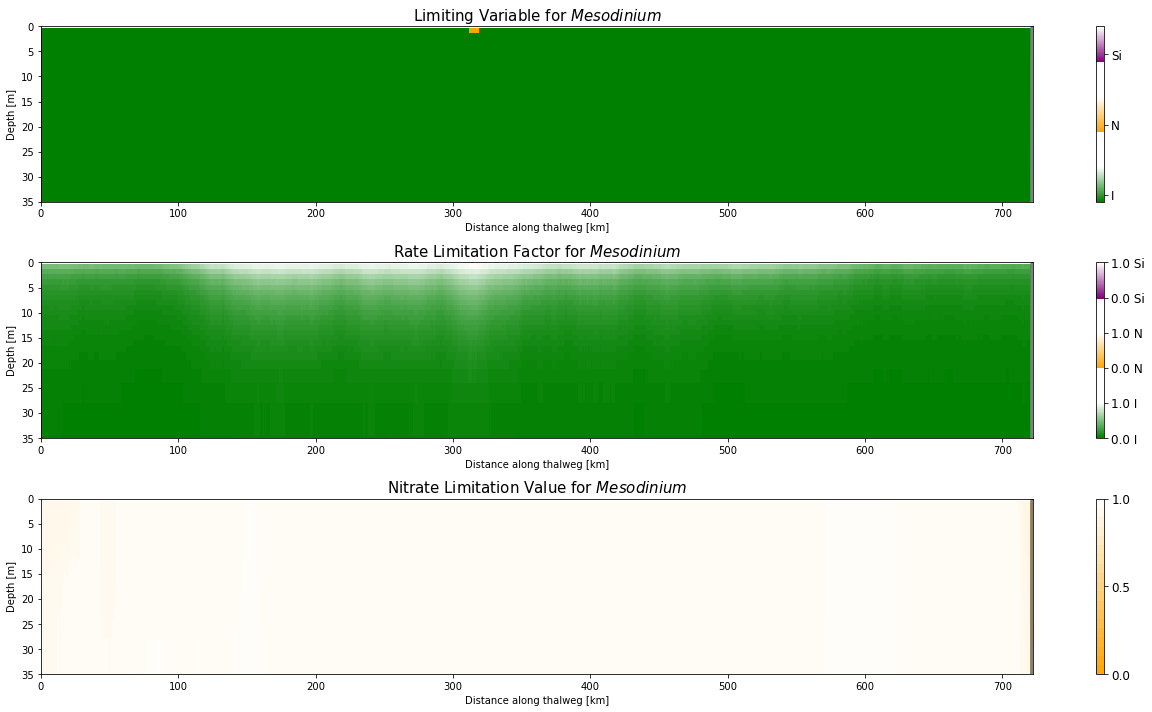

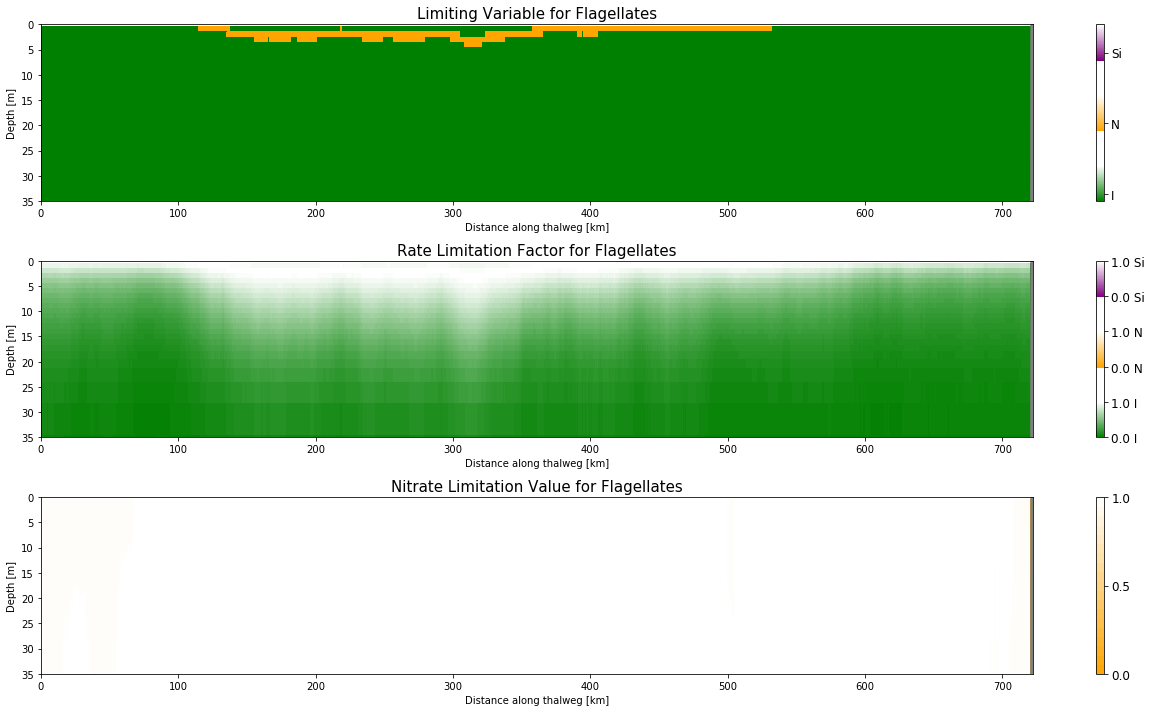

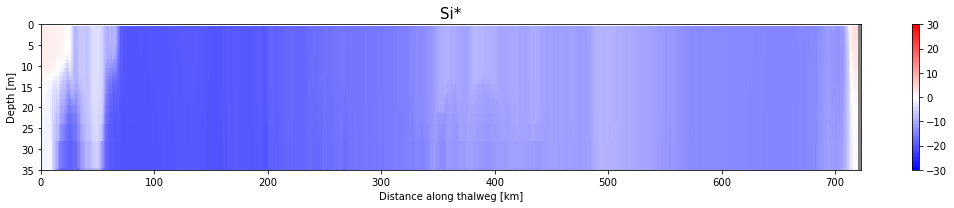

In [107]:
limit_along_thalweg('/results/SalishSea/nowcast-green/03dec15', 
                    'SalishSea_2h_20151203_20151212_dia1_T.nc',
                    'SalishSea_1h_20151203_20151203_ptrc_T.nc', 'N')
limit_along_thalweg('/results/SalishSea/nowcast-green/03dec15', 
                    'SalishSea_2h_20151203_20151212_dia1_T.nc',
                    'SalishSea_1h_20151203_20151203_ptrc_T.nc', 'dia')
limit_along_thalweg('/results/SalishSea/nowcast-green/03dec15', 
                    'SalishSea_2h_20151203_20151212_dia1_T.nc',
                    'SalishSea_1h_20151203_20151203_ptrc_T.nc', 'meso')
limit_along_thalweg('/results/SalishSea/nowcast-green/03dec15', 
                    'SalishSea_2h_20151203_20151212_dia1_T.nc',
                    'SalishSea_1h_20151203_20151203_ptrc_T.nc', 'flag')
plot_excess_silicate(nc.Dataset(
    '/results/SalishSea/nowcast-green/03dec15/SalishSea_1h_20151203_20151203_ptrc_T.nc'))